# Эксперименты с данными для проверки адекватности модели

## Введение

ИСПОЛЬЗУЕМЫЕ БИБЛИОТЕКИ

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta
import math

ФУНКЦИЯ ПОЛУЧЕНИЯ РЯДОВ ИЗМЕРЕНИЙ

In [2]:
def create_z(y):
    res = []
    for j in range(4):
        zn = []
        for i in range(len(y[j])):
            zn.append(y[0][i] - y[j][i])
        res.append(zn)
    return res

ИСХОДНЫЕ ДАННЫЕ

In [3]:
def AR1(fi, r):
    return r * fi


def Reg(a, b, c, x):
    return a + b * x + c * (x ** 2)

ДАННЫЕ ДЛЯ РАСЧЁТА ОЦЕНКИ ТОЧНОСТИ ПРОГНОЗИРУЮЩИХ МОДЕЛЕЙ

In [4]:
def est(X, Y0, count):
    ep = []
    for k in range(4):
        e = 0
        for i in range(count):
            e += (Y0[i][k] - X[i][k])**2
        ep.append(e)
    return ep

ПОСТРОЕНИЕ АВТОРЕГРЕССИОННОЙ МОДЕЛИ (ПОДБОР ПАРАМЕТРОВ МЕТОДОМ СОПРЯЖЕННЫХ ГРАДИЕНТОВ)

In [5]:
def adaptive_function(series, autoregress_coef_, cnt, variation_, cnt_of_pr, modelseries_ = None, remainders_ = None):
    
    autoregress_coef = autoregress_coef_
    pr = [0 for i in range(cnt)]
    variation = [variation_ for _ in range(cnt)]
    change = [0 for i in range(cnt)]
    var = [variation_ for _ in range(cnt)]
    
    
    for k in range(cnt, cnt_of_pr):
        
        pr.append(autoregress_coef * series[k-1])
        change.append(series[k] - pr[k])
        var.append(change[-1]**2)
    
    return (pr, sum(var)/(cnt_of_pr-1))

def object_function(series, xk):
    new_series, remainders = adaptive_function(series, xk, 0, 0, len(series))
    return remainders
 
def gradient_function(series, xk):
    dt = 10**(-7)
    new_value = object_function(series, xk + dt)
    value = object_function(series, xk)
    return (new_value - value) / dt

def optimization_func(series, y1, d1):
    alpha = 0
    step = 4
    
    while step > 10**(-7):# or object_function(series, y1 + (alpha+step)*d1) < object_function(series, y1 + alpha*d1):
        if object_function(series, y1 + (alpha + step) * d1) > object_function(series, y1 + alpha*d1):
            step /= 2
        else:
            alpha += step
    
    return alpha

def conjugate_gradient(series):
    eps = 10**(-7)
    
    init_autoregressive_coef = 0
    y1 = init_autoregressive_coef
    d1 = -gradient_function(series, y1)
    j = 1
    gamma = 0
    
    while abs(gradient_function(series, y1)) >= eps:
        gamma = optimization_func(series, y1, d1)
        y2 = y1 + gamma*d1
        
        d1 = -gradient_function(series, y2) + (gradient_function(series, y2)**2)/(gradient_function(series, y1)**2) * d1
        gamma = optimization_func(series, y2, d1)
        y1 = y2 + gamma*d1

        d1 = -gradient_function(series, y1)
        if abs(y2 - y1) <= eps:
            break
        j += 1
    
    return (y1, object_function(series, y1))

ФУНКЦИЯ ДИНАМИЧЕСКОЙ ОБРАБОТКИ ЧАСТОТНО-ВРЕМЕННЫХ ДАННЫХ

In [6]:
def get_norm_of_g(init_g):
    return [init_g[i]/sum(init_g) for i in range(len(init_g))]

In [7]:
def dynFilZ(X, sigma1, sigma2, count, n):
    If = []
    Lf = []
    z = []
    zch = []
    yp_m = []
    yp_st = []
    yp_t = []
    zp_st = []
    yp = []
    zp_t = []
    y = []
    Lambda = []
    alpha = []
    Beta = []
    BETA1 = []
    BETA2 = []
    BETA3 = []
    ya = np.transpose(YA)
    est_yp = []
    est_y = []
    MAIN_ARRAY = []
    e_yp_p = np.transpose([0. for _ in range(n)])
    
    dots = 15
    
    # ДЛЯ АДАПТАЦИИ
    autoregress_coef = np.transpose([[0.0 for __ in range(count)] for _ in range(n)]) # коэффициент авторегрессии phi
    cnt = 14 # номер точки начала адаптации (меньше на единицу для определения начальных точек прогноза)
    trend = np.transpose([[0.0 for __ in range(count)] for _ in range(n)]) # угловой коэффициент b1 тренда
    change = np.transpose([[0.0 for __ in range(count)] for _ in range(n)]) # dy (ошибка прогноза)
    var = np.transpose([0.0 for i in range(n)]) # сумма квадратов ошибок прогнозов dy^2
    norm_var = np.transpose([[0.0 for __ in range(count)] for _ in range(n)]) # дисперсия D
    R = np.transpose([0.0 for _ in range(count)]) # коэффициент адаптации
    # КОНЕЦ ДЛЯ АДАПТАЦИИ

    g1 = []
    for i in range(n):
        g1.append(1/(sigma2[i]/2))
      #g1.append(1/math.sqrt((sigma2[i]/2)))
    g = []
    g_part = 0
    for j in range(n):
        g_part += g1[j]
    for i in range(n):
        g.append((g1[i]/g_part))

    s0 = []
    for i in range(n):
        s0.append((((sigma2[i]/2)**2)*(dots-2)))
    for s in range(count):
        Ip = np.transpose([1 for _ in range(n)]) 
        Lp = np.transpose([1 for _ in range(n)])
        deltaZ = np.transpose([0. for _ in range(n)])
        dyst = np.transpose([0. for _ in range(n)])
        dy = np.transpose([0. for _ in range(n)])

        yp_m_p = []
        yp_st_p = []
        yp_t_p = []
        yp_p = []
        zp_t_p = []
        for k in range(n):
            if s == 0:
                yp_m_p.append(AR1(Ar[k], Y_0[k] - Reg(RegC[0][k], RegC[1][k], RegC[2][k], s+cnt)))
                yp_st_p.append(Step_y[k])
            else:
                yp_m_p.append(AR1(Ar[k], y[s-1][k]))
                yp_st_p.append(yp_st[s - 1][k])
                deltaZ[k] = X[s][k] - X[s - 1][k]
                if abs(deltaZ[k]) > (sigma1[k] * 6):
                    X[s][k] = X[s - 1][k]
                    print("Такт выброса: ", s)
                    print("Генератор выброса: ", k)
                    Ip[k] = 0
                    deltaZ[k] = 0
                if abs(deltaZ[k]) > (sigma2[k] * 3):
                    Lp[k] = 0
            yp_t_p.append(Reg(RegC[0][k], RegC[1][k], RegC[2][k], s+cnt)) # изменить
            yp_p.append(yp_m_p[k] + yp_t_p[k] + yp_st_p[k])
            zp_t_p.append(yp_t_p[0] - yp_t_p[k])
        yp_m.append(yp_m_p)
        yp_st.append(yp_st_p)
        yp_t.append(yp_t_p)
        yp.append(yp_p)
        zp_t.append(zp_t_p)
        if (sum(Lp[1:]) == 0) and (s > 0):
            Lp = [0 if i == 0 else 1 for i in range(n)]
            dy1_summ = 0.
            for i in range(1, n):
                dy1_summ += deltaZ[i]
            dy1 = dy1_summ / (n-1)
            yp_st[s][0] = yp_st[s][0] + dy1
        else:
            for k in range(1, n):
                if Lp[k] == 0:
                    dy[0] = yp_t[s][0] - yp_t[s - 1][0] + yp_m[s][0] - yp_m[s - 1][0]
                    dy[k] = yp_t[s][k] - yp_t[s - 1][k] + yp_m[s][k] - yp_m[s - 1][k]
                    dyst[k] = -deltaZ[k] + dy[0] - dy[k]
                    yp_st[s][k] = yp_st[s][k] + dyst[k]
        zp_st_p = []
        If_p = []
        Lf_p = []
        z_p = []
        zch_p = []
        y_p = []
        for k in range(n):
            zp_st_p.append(yp_st[s][0] - yp_st[s][k])
            If_p.append(Ip[k])
            Lf_p.append(Lp[k])
            z_p.append(dy[k])
            zch_p.append(X[s][k] - zp_st_p[k] - zp_t[s][k])
        zp_st.append(zp_st_p)
        If.append(If_p)
        Lf.append(Lf_p)
        z.append(z_p)
        zch.append(zch_p)
        summ = 0
        for j in range(n):
            summ += (zch[s][j] + yp_m[s][j]) * g[j]
        y_p.append(summ)
        for k in range(1, n):
            y_p.append(y_p[0] - zch[s][k])
            yp[s][k] = y_p[k] + yp_st[s][k] + yp_t[s][k]
        yp[s][0] = y_p[0] + yp_st[s][0] + yp_t[s][0]
        y.append(y_p)
        
        # АДАПТАЦИЯ
        
        for k in range(n):
            zch[s][k] += zp_t[s][k] # возвращение трендов в ряды измерений для их адаптации
        
        R[s] = 1/(s + cnt +1)
        for k in range(n):
            if s == 0:
                autoregress_coef[s][k] = Ar[k]
                trend[s][k] = RegC[1][k]
                
                yp_t[s][k] = trend[s][k] * (s + cnt) + RegC[0][k]
                yp_m[s][k] = autoregress_coef[s][k] * ( Y_0[k] - yp_t[s][k])
                yp[s][k] = Y_0[k]
                
                var[k] = SRm[k] * SRm[k] * (cnt - 2)
                norm_var[s][k] = SRm[k] * SRm[k] * (cnt - 2)
                
            else:
                yp_t[s][k] = trend[s-1][k] * (s + cnt) + RegC[0][k]
                zp_t[s][k] = yp_t[s][0] - yp_t[s][k]
                yp_m[s][k] = autoregress_coef[s-1][k] * yp_m[s-1][k]
                
        
        if s > 0:
            y[s][0] = sum([g[k] * (zch[s][k] + yp_m[s][k] - zp_t[s][k]) for k in range(n)])
            
            yp[s][0] = y[s][0] + yp_t[s][0]
            
            for k in range(1, n):
                y[s][k] = y[s][0] - zch[s][k] + zp_t[s][k]
                yp[s][k] = y[s][k] + yp_t[s][k]
            
            for k in range(n):
                change[s][k] = yp[s][k] - yp_m[s][k] - yp_t[s][k]
                
                trend[s][k] = trend[s-1][k] + (R[s-1] * change[s][k])
                yp_t[s][k] = trend[s][k] * (s + cnt) + RegC[0][k]
                zp_t[s][k] = yp_t[s][0] - yp_t[s][k]
    
            y[s][0] = sum([g[k] * (zch[s][k] + yp_m[s][k] - zp_t[s][k]) for k in range(n)])
            
            yp[s][0] = y[s][0] + yp_t[s][0]
            
            
            for k in range(1, n):
                y[s][k] = y[s][0] - zch[s][k] + zp_t[s][k]
                yp[s][k] = y[s][k] + yp_t[s][k]
            
            for k in range(n):
                change[s][k] = yp[s][k] - yp_m[s][k] - yp_t[s][k]
                
#                 print(f'change[{s}][{k}] = {change[s][k]}')
                
                autoregress_coef[s][k] = autoregress_coef[s-1][k] + (R[s-1]*change[s][k]*yp[s-1][k])/(abs(yp[s-1][k])) 
                if abs(autoregress_coef[s][k]) >= 1: 
                    autoregress_coef[s][k] = autoregress_coef[s-1][k]
                
                Ar[k] = autoregress_coef[s][k]
                RegC[1][k] = trend[s][k]
                yp[s][k] += yp_st[s][k]
                
                var[k] += (change[s][k])**2
                norm_var[s][k] = var[k] / (s + cnt - 2)
                
                g[k] = 1 / math.sqrt(norm_var[s][k])
                
                
            g = get_norm_of_g(g)
        
        
        # КОНТРОЛЬ АДЕКВАТНОСТИ
        Lambda_part = []
        for k in range(n):
            e_yp_p[k] += (ya[s][k] - yp[s][k]) ** 2
        est_yp.append(e_yp_p.copy())
        for k in range(n):
#             Lambda_part.append(((sigma1[k]**2) / ((sigma1[k]**2) + est_yp[s][k])))
#             Lambda_part.append(((s0[k]**2) / ((s0[k]**2) + est_yp[s][k])))
            Lambda_part.append(((s0[k]) / ((s0[k]) + est_yp[s][k])))
        Lambda.append(Lambda_part)
        alpha.append((dots + 1) / 2)
        Beta.append((s+1) / 2)
    BETA1.append(beta.ppf(0.25, alpha, Beta))
    BETA2.append(beta.ppf(0.1, alpha, Beta))
    BETA3.append(beta.ppf(0.05, alpha, Beta))

    MAIN_ARRAY.append(np.transpose(yp)) # 0
    MAIN_ARRAY.append(If) # 1
    MAIN_ARRAY.append(Lf) # 2
    MAIN_ARRAY.append(np.transpose(yp_st)) # 3
    MAIN_ARRAY.append(np.transpose(yp_t)) # 4
    MAIN_ARRAY.append(np.transpose(z)) # 5
    MAIN_ARRAY.append(np.transpose(y)) # 6
    MAIN_ARRAY.append(np.transpose(Lambda)) # 7
    MAIN_ARRAY.append(BETA1) # 8
    MAIN_ARRAY.append(BETA2) # 9
    MAIN_ARRAY.append(BETA3) # 10
    MAIN_ARRAY.append(np.transpose(autoregress_coef)) # 11
    MAIN_ARRAY.append(np.transpose(norm_var)) # 12
    MAIN_ARRAY.append(np.transpose(trend)) # 13
    MAIN_ARRAY.append(est_yp) # 14
    

    return MAIN_ARRAY

# Проверка работоспособности

Пример с самостоятельно сгенерированными рядами

In [8]:
# Y_0 = np.transpose([27.49456, -71.25896, 47.16386, 1.80931])
# Ar = np.transpose([0.064934213, -0.3501422918, -0.193565713, 0.07319836])
# SRm = np.transpose([0.37580, 0.59773, 0.65471, 0.92481])
# SR_Sum = np.transpose([34.641988, 26.051902, 34.58301536, 51.9387592]) # SR_Sum[j] = SR1[1] + SR1[j]

# RegC = [[24.9223700, -72.998730, 50.905291, -4.9920256815],
#         [0.2155039, 0.100693, -0.2283322, 0.4159401],
#         [0, 0, 0, 0]]
# Step_y = np.transpose([0, 0, 0, 0]) # Ступенчатые функции на начало

# Y = [
#     [27.49456645438907, 28.529660852734015, 28.321456893004477, 27.89248225780759, 29.391766737700685, 29.2533656956134, 28.83965963349811, 28.538743433875165, 29.503906457720944, 29.105976122560186, 28.955349745667174, 30.16724077725902, 30.060560407439038, 30.712882376981696, 30.7544534534808, 30.699232123190903, 31.280833251645866, 31.448799188339265, 31.61892963265474, 31.59588189502902, 31.954533905886457, 31.5091038660654, 32.55937133082463, 32.77632624601588, 33.13444796718504, 32.925820269297375, 32.465298728243624, 33.34368305078672, 32.688069421961096, 33.194831312103155, 34.68424264972623, 33.91006949103159, 34.776730030562774, 33.56092542983001, 34.50187554850614, 34.343880599748196, 34.26817777736378, 35.703003404516814, 34.752281137494855, 35.30018925250755, 35.82943545833999, 35.855327583815296, 35.58137537617524, 35.54582643176212, 37.08399602794348, 37.038686167615005, 36.12316110275259, 36.968345886103634, 37.64009852711987, 37.831042977994215, 37.46794613642018, 37.93043170652673, 38.42788075417212, 38.871164239520546, 38.71103342307644, 38.807742793642426, 39.019967256321436, 39.195630924313186, 39.05746007191471, 39.29681130316793, 39.74740259534235, 39.77336068180756, 39.65203690258623, 40.310251407185504, 40.45678125104805, 40.85417574361919, 40.82527589874173, 42.35513401668302, 41.16987642573875, 41.59447706994022, 42.31053435418961, 41.72721259908572, 41.65442268970864, 41.81067229192944, 42.91390934344851, 42.34130456042767, 43.70945000524579, 42.466868477207576, 43.37133356606863, 43.93428968745979, 44.020904049676325, 44.58128790728343, 44.007389669930014, 44.75871473697213, 44.70944758324014, 44.89316098380412, 44.360876321507654, 45.52653368094984, 45.797256048215836, 45.91771031684589, 45.907100195305595, 45.79381024124794, 45.91008069709984, 45.799058313233324, 47.00850640523816, 47.71119647592042, 48.379061021392054, 47.480937186628395, 46.799765273496156, 47.513380776426125, 48.11504899976063, 48.62592778612381, 48.395877935481856, 48.908853734926595, 48.57970168145347, 48.4806222321639, 48.77623450442797, 48.56819492057855, 49.49454484758628, 49.1192042659273, 49.107680150732016, 50.18268431450546, 49.54518316077852, 50.32265368738615, 50.292488035810884, 51.16319346884306, 51.549244751116916, 51.275601469527665, 51.216664122006954, 51.3291723869664, 52.24799891724517, 51.72089055952365, 52.2880631476782, 53.41765583321718, 52.50796004034619, 53.205759842552304, 52.77551432589292, 53.527900185895376, 53.56953320793637, 53.5129747044875, 54.258998947538295, 54.370290068843005, 54.35714563756199, 55.04712748149152, 55.02611369350276, 55.112137074299, 54.78121335257985, 55.551543877597204, 56.384143196910216, 55.647847204089096, 55.52266964055959, 55.842125735907636, 55.949042036806496, 56.21320945334824, 55.96092854200804, 56.24746261308709, 57.24487447840085, 57.55232514965151, 57.22037526864317, 57.12033592736318, 57.50902444758057, 57.03387694311671, 58.40418046217382, 58.15736467903379, 58.8317067771686, 59.58359739899882, 59.04290286329942, 58.597999606147106, 60.17158212464223, 59.211935014264505, 59.28386892778332, 60.61009225071409, 61.49072032947817, 60.058235031376036, 60.63832612912942, 61.761437561232945, 60.9375789552096, 60.926314693923594, 61.384472441456246, 61.220969418127794, 61.31520216316362, 61.1993954886703, 63.03887352410998, 62.29642229687352, 62.76919852938451, 62.84023830507926, 63.130260581477955, 62.66972076992773, 63.71358354717032, 62.73264476480503, 64.71013882820446, 64.74733543389317, 64.30651912720877, 63.587811733418654, 64.07495560904879, 64.1290741058967, 65.00128670016848, 65.29113115034247, 66.31704033105717, 65.8766369039743, 65.85640998226816, 66.51700823140096, 66.94736065574445, 67.11543170002857, 66.85301792761713, 66.10289814308365, 66.99265377155598, 67.14693383723217, 67.354016598733, 67.11532251357673, 68.55728026169551, 67.31860331974339, 68.73356534301482, 67.85098485593204, 68.52127145347578, 69.75664430245443, 69.15092292002979, 69.08189743000682, 68.90356912514783, 69.05653850641886, 69.30981110667923, 69.88869852145919, 71.46109736826568, 70.04292315240019, 69.96817423732004, 71.04527673187596, 71.28534932801539, 72.00777712434102, 72.35413498440317, 71.88773447488096, 71.55809455342371, 71.68148005606194, 72.79917501203573, 72.00079827148072, 72.53654117850196, 72.56326900040158, 72.78771578334526, 72.72789033353322, 73.77899168680868, 73.4085607040743, 73.44508863257249, 74.41376727713133, 73.85153926892933, 73.4732985826225, 74.56194937321777, 74.65979316616144, 74.96333972767886, 75.20087630163961, 75.65342955345248, 76.11664378521367, 76.36945332797, 75.84045640369445, 75.39026971942482, 76.11433625643545, 76.86615614320998, 76.23282629653278, 76.46986530177959, 76.79660169139898, 76.51276223182563, 77.1333396988468, 78.38451182318227, 78.90972147769429, 78.78802143414849, 78.04101207946262, 78.9461979952431, 79.28949537178515, 78.74090022989412, 79.41949263016012, 79.81065969491625, 79.62186711724347, 79.48886633218424, 79.00444853041296, 80.04339085301608, 80.33735860984456, 80.65891724798996, 80.7099338051482, 81.15568113215006, 81.06517256285123, 82.03434794418051, 82.45505107763498, 81.91193086612708, 82.16782311709085, 81.76115078051585, 81.92950837406158, 82.47633846374588, 83.5120147078483, 83.2772357595398, 83.22253160788276, 83.60828103998398, 82.60194922975398, 83.87901673945888, 83.88056199824389, 84.2757254515461, 83.90138336992648, 84.02256568006965, 84.11030802658848],
#     [-71.258962804646, -71.34512627621027, -72.27600321158279, -70.82981115827059, -70.71640293866797, -70.8562929563788, -70.87032494476016, -70.27108308014878, -70.07945026559138, -70.87010101808823, -70.81377779615879, -70.66632887310728, -71.18018394394298, -70.69879599108941, -70.49999103182076, -70.65734077003012, -70.07305016334442, -68.8699616907873, -69.82452840593226, -69.6333832899893, -69.02081926921444, -69.59425965034214, -69.79909712438256, -70.3377187277106, -69.71568552588234, -69.0299326597869, -69.4419081167449, -69.36652056260165, -68.35419780749831, -67.99768726044367, -68.51657969300359, -68.84706184582531, -68.89990290715645, -68.63232544641504, -68.86628239129533, -68.35519297637434, -67.74068983394395, -67.47581351844465, -67.79195813465105, -67.36873791142354, -67.6136865659479, -67.95816831095212, -68.30108633969623, -67.63441506264934, -68.28106682651638, -67.10965939567645, -66.8187464302928, -66.92052752349936, -67.21210289387716, -68.49182896046979, -67.52933109499492, -65.72288330066414, -65.36003827087431, -65.53216443300127, -66.26646165440062, -65.86525341662447, -64.87204508226989, -64.84080749185254, -64.53839381671371, -65.47253936178262, -65.65136733872039, -65.03229135968638, -65.89895251951995, -65.68920037169525, -65.34510240579554, -65.49446312007515, -64.70447215842486, -65.00555426127417, -64.90778459601084, -64.46089711317539, -65.41950400567212, -65.19525569528166, -64.67845748838141, -65.10129308628925, -64.04493533393585, -64.50762595477076, -64.3599657925347, -63.70366788511866, -63.697180447206115, -64.17708806860892, -64.01580120045475, -63.98437698815355, -63.01337543786469, -62.84221395658225, -62.70308857104781, -63.114535584732664, -63.03951175788758, -63.02957680050022, -63.20088711522432, -62.44778858885425, -61.9348519313822, -62.071522326897465, -62.99411675709135, -61.80591994201035, -62.012208726515176, -62.46597486335848, -62.23517995571223, -62.3274889806666, -61.20923969898796, -60.88398179772755, -62.13524442243798, -61.9659361247721, -62.44603435536534, -61.777108485812846, -61.75015590329707, -61.71319974669548, -61.04506408906366, -61.55875060631076, -61.38591097669191, -61.2211260174914, -60.65184029473242, -60.56054537232043, -60.49942239992565, -60.10312440503061, -59.91586096539468, -59.644678592694284, -59.685476570378164, -60.0113101560317, -60.04371757043195, -59.88538524874555, -59.590082363925156, -59.38946471382683, -58.977817179602894, -58.87946726713083, -59.417681273288274, -59.394211124488294, -58.91387682322761, -59.25664872977207, -59.5848986473735, -58.565671591596775, -57.34440422493021, -58.378408698524964, -58.517295460286, -57.62330557510258, -58.00798433046378, -58.863323110335486, -57.173255349446926, -56.943065406027166, -57.385198576667186, -56.90091325955184, -57.28671282154191, -57.703145434099305, -57.978970074684774, -58.16560329677379, -57.446123849220236, -56.90700221198309, -56.87199668197449, -56.800019432280294, -57.03987470218522, -56.583951896714176, -56.656852192037206, -56.836108013633265, -56.43021452329559, -56.72487307162886, -56.13687646026305, -56.43110537455323, -55.94636408254223, -55.781385625667944, -56.14485466574131, -55.53054854043242, -55.2270760538153, -55.04348931897171, -55.45233241057421, -56.14488024960346, -55.90037397371517, -55.04055131012871, -54.84490890169919, -54.936405838603115, -55.815222771089104, -53.95865746989869, -54.10953743452271, -55.42751349945599, -53.944267028731545, -54.55405386510718, -54.80093411702237, -54.88530868278102, -54.8527540336254, -54.478896954755434, -54.85570913954353, -53.67805859507714, -53.011214405460954, -53.421111898513985, -53.44435519912747, -53.314498948807305, -53.43932922790164, -54.29330676129583, -53.791915015290236, -52.60102996577723, -51.746717126174346, -52.889119283283364, -52.585633424084115, -51.77826739704259, -51.72403708102892, -52.801925553279915, -51.67900764328643, -50.9121315464938, -51.71864717362579, -51.40147707166242, -51.19753641871648, -51.24360324460452, -51.63012757077146, -52.172888408337734, -51.44036737979699, -51.15116627106218, -50.651941930149235, -50.95951611558744, -50.882873076058, -50.52093589540573, -50.651430584281215, -49.06626154796902, -50.30930577216579, -51.03624169240303, -49.91735431194966, -50.02490118850916, -50.09921778123282, -50.46362013877741, -50.42993767360577, -49.60637286222459, -49.660259180439816, -49.90213031148977, -49.2261603939029, -49.430677214131855, -50.22152210100137, -49.69799516053111, -49.14446363711924, -49.50722427645143, -49.818564891339406, -50.032923381913946, -48.357653647353494, -48.379274777678994, -49.00515244131534, -48.3405810470572, -48.8148258884058, -48.47622945329468, -48.189162794202446, -48.3280267885832, -48.57066913419558, -47.80705488361449, -47.51790903025773, -47.47042126312888, -48.00436889297837, -47.65160857104089, -47.06284560973853, -46.852632471349764, -46.82020825924763, -46.967607346095335, -46.40189298072188, -46.65816627759975, -46.49967078350934, -46.720118013711804, -46.0049252118789, -46.413839070003135, -46.03590481420897, -46.772497541241464, -46.06020808617251, -45.68006760963476, -45.33184920335155, -45.64334511171335, -45.24198901096323, -45.33030597712414, -45.296707168364605, -45.880356539747076, -45.1476574451588, -44.68251880483853, -45.309647316456015, -44.98311606027711, -45.05196982380302, -44.77125165856524, -45.22372055671778, -46.0973550162449, -44.62725209036138, -44.35301149570698, -44.87017229505425, -44.61642904414312, -43.99685499994503, -43.596459674735875, -43.10103109037309, -42.72038356746872, -43.5263545973762, -43.56926544738296, -43.83412378905674, -42.76177405979776, -42.889411829853096, -43.33561953242802, -42.82403304195877, -42.855831289536],
#     [47.16386378760977, 47.786424467228834, 47.48110164349731, 47.26204369033421, 47.971551541884075, 47.876525034917336, 46.41685273663814, 46.317611164840635, 47.71757050492909, 47.372683126223684, 46.280552377501465, 46.40272263343945, 45.87160641020593, 45.69015646340493, 45.75234151478435, 45.033002967588565, 44.135131280406206, 44.733183718680856, 45.14202118084193, 44.38945352248296, 43.523256773559886, 43.06737004890696, 42.315270862207946, 42.33740091877008, 42.30340474449155, 41.8184342950332, 42.23241066528408, 41.47051107566363, 41.60992106022003, 42.52005568211489, 43.01441704957055, 42.8501525855714, 42.07817101814058, 41.77922518569854, 41.31089054916739, 41.14710970737031, 40.47561078822125, 40.604737891837516, 41.49212694104564, 40.43756448926319, 39.89419231954985, 40.02629260190575, 39.49454853697805, 39.57568726027597, 39.58387380245255, 38.766598544474434, 38.24511056859788, 38.657095758422656, 39.11986143734509, 37.908955611281996, 37.234559508849145, 37.24470572051777, 37.89084737426934, 37.72170824314134, 36.60998474874077, 35.9353814082444, 36.67640158512324, 37.97967093470438, 36.85426929955704, 36.133667457027045, 36.42036075188824, 36.33326549401048, 35.69826944190996, 35.06435405205794, 34.78016524952285, 35.715555322782635, 35.137225022919544, 34.17765143302612, 34.69790355680725, 34.45684666522427, 34.074065929693994, 34.44859301615194, 34.18155510399445, 33.4133112466038, 33.81911327106903, 33.74809029137111, 33.37202992844431, 32.79707160950708, 32.29250914000492, 31.844685894884485, 32.375015100284244, 32.11282408814649, 31.856230322993316, 32.31309870040469, 31.194639474565456, 30.105463119298175, 30.526852905313156, 31.233450513565586, 31.286885579046533, 30.242873628400357, 30.194454875892326, 30.04986846338561, 29.854566056141998, 29.11557918604619, 28.72203171819819, 28.7688601859039, 28.796104616006467, 29.328782869540966, 29.112910250354574, 28.961376426159877, 28.451729890326323, 27.65571065966229, 27.39466731670004, 27.552764363662554, 26.9820793358582, 26.059035953567157, 26.665459651732927, 25.677524675003834, 26.68137257459819, 27.44849273887252, 26.342718626381075, 25.846159744357927, 25.674231078372742, 25.55748851051933, 24.517655914828865, 24.593173843367662, 25.091622215228927, 24.412307451970943, 23.618401204301, 24.18529302795891, 24.213708998791347, 24.183575685477045, 24.8688179181739, 24.691733357502706, 23.754585528158714, 21.68555180003738, 22.112702933433518, 22.95000698113457, 22.580535855347062, 23.17878918609387, 22.674326462281385, 21.412950826698747, 20.887953381134807, 21.72307408339396, 21.167080261419635, 19.873540566565005, 20.120542920308555, 20.37963005831528, 19.97579437458314, 19.61920771972291, 20.765005590240932, 21.28080826599182, 19.473722810217264, 19.944310808519123, 20.32635166104011, 19.96046765272101, 20.211585157254767, 19.73606606262641, 19.72774034684358, 18.987365942653962, 18.1978412448778, 18.027804543668392, 17.892595553046853, 17.451790022257917, 17.26565190135798, 17.124951689300833, 16.531405405058337, 16.71171506924844, 16.42691367896148, 15.912216700850433, 16.12467120200811, 16.168227764801973, 15.74565309616773, 16.059342305654273, 15.701318576111474, 14.67373640262424, 14.575978665971231, 14.171568758186131, 14.669329840305256, 14.18182740598785, 13.721937816887399, 14.201923677491335, 13.54603118969985, 12.367734684933096, 12.818747975199628, 13.064815616879649, 12.946280560083991, 12.236976916381385, 12.386255516373282, 13.203735200047365, 12.599307305600805, 11.611196595159806, 11.408863320975987, 11.148180217502826, 11.20616556786544, 11.962067646330482, 11.762486041159182, 11.335729989932073, 10.071170859249364, 8.679864674886646, 10.10534923406186, 10.894225175306643, 9.92714550390487, 9.294361578340837, 9.698469324668086, 9.339340644516854, 7.914888946011731, 7.171845377490025, 8.206371046408385, 7.343010340314413, 6.9449099132559615, 7.98043772263584, 7.547957553974494, 6.711954168398947, 7.503463107741453, 6.965457491958642, 5.951129710757096, 6.0478540036120965, 6.938254672519602, 7.060102054467116, 6.866375095777161, 6.869412877493163, 6.445813237625253, 5.883032898876787, 5.2681553918799, 5.319032830333033, 4.331238446287748, 4.464613284083545, 5.1801129029452735, 5.2549363265496485, 4.6111958094971115, 4.004182930691211, 3.4911734551900953, 3.2359083017245633, 3.907502707605955, 2.94839633267833, 2.215394095823987, 3.0662617787370827, 2.308756164411606, 1.5882661390291566, 1.3335960415406196, 1.6838355998371153, 2.240887795382632, 2.1344546304759704, 1.8580661228805733, 1.1380216983018667, 0.7767985801196858, 0.3944699189337964, 0.6120707848437451, 1.8400984176498894, 1.014644937421249, 0.13770104258506094, 0.05644926666643796, -0.6521265332091333, -1.1799389837378609, -1.6075655851251134, -1.3911570671243967, -0.8628368129714056, -2.235606148809755, -1.9043273902886275, -0.9166086332585954, -2.1475411741221633, -2.95842177047514, -2.6221982842812905, -3.1616967618193645, -3.3649887460334083, -2.8185216717425927, -3.0002435853160536, -3.8090217292431134, -4.498988498276624, -4.426842448376664, -4.896025053204536, -4.85275335048049, -4.523644376032326, -4.796692176823911, -4.884630013723093, -4.277726781486433, -4.1973261493288305, -4.6395259762010586, -5.285947555079614, -4.927250434235278, -4.314154478835565, -5.411411244481702, -6.3356064340859275, -5.674839781197602, -6.203150740876923, -6.166559867170058, -6.5454815751078765, -7.661060172544387, -7.740905056165478, -7.265256204872863, -7.045311422587706, -7.0775316928336505, -8.270620639915062, -9.398318202834055, -10.258635313086614],
#     [1.8093142850305328, 0.1991731116862986, 2.1451270835054768, 1.837360253911986, 2.564569770839116, 3.1156159378038595, 2.5355170822812068, 4.273667942378456, 3.3100950192956318, 4.539823480221557, 5.06605532654658, 5.119594142902043, 4.82270507744381, 5.4780016963612415, 6.28162481395987, 6.112913894752737, 6.466057452605108, 7.819644805845214, 8.127405196922554, 8.040348725739925, 8.372458182858455, 8.5121827320194, 9.927964473192915, 9.428994131329333, 10.767502695730418, 10.61568699263497, 11.748718441413908, 11.749994616224837, 10.946842473600935, 13.18077512861595, 11.716091963481539, 13.421934085305274, 13.13324063360987, 13.522406527279106, 14.098624717743458, 14.29284971685424, 14.260467382567818, 15.7555810175621, 16.23588610268702, 15.787579181801265, 17.07198404683039, 15.88649656276041, 17.207148768086995, 17.84024606601695, 19.176750700008334, 19.187229725031013, 19.257612808709943, 20.03909401385444, 19.132083031904997, 20.820854307589315, 20.687942217665864, 20.631082788354632, 21.60774700951847, 22.000581073420072, 22.177332867683692, 22.317016166961245, 23.39663162643129, 24.017866794953232, 23.467190908748346, 23.49593539490946, 23.85533605240528, 24.89001921586154, 25.186376588096152, 26.86212094439963, 26.389319399650148, 26.183567048444917, 26.142377974747685, 28.195335310793386, 28.730170144208948, 28.15049537093533, 27.739201347063226, 29.133875456819435, 30.046570532799638, 29.614586349610665, 30.593591093443774, 30.9285806120423, 30.554950711265604, 31.62633544517623, 31.3603824507394, 32.29420657231512, 33.172882231433356, 33.069742383984995, 33.323470044737206, 32.606147435201216, 34.561487639976576, 34.86956645306458, 34.81586378261573, 35.30628123962985, 35.38637149589834, 35.705747267268066, 36.95446153787394, 37.650493601342596, 37.26429249940933, 37.537545959411716, 37.903084413380924, 38.30347249690634, 39.66682638459248, 39.3704018855351, 39.59173751848111, 39.5316007679897, 40.553355193184274, 40.87036202174647, 41.19935010447774, 40.21729152140296, 43.53651582216417, 42.95533002235985, 42.46413678250898, 43.88470412550378, 44.027729918621745, 44.43909006008101, 44.4295231286869, 45.13733739962838, 46.46251047327832, 46.04794531681482, 45.93477927195309, 46.732604874154966, 47.47043747785793, 46.24974888567274, 47.74568215119262, 49.17482451229067, 47.784347541557615, 49.18248000540678, 48.9669810285304, 50.0597919920345, 49.666841103793956, 50.361412222223336, 51.652261381405665, 51.09606424871373, 52.32307764998782, 51.39416509063275, 52.625459723300295, 52.87230245545456, 53.32290184739708, 53.93536846416659, 54.007899268131496, 54.55291395078407, 54.80556970759329, 55.56261096067958, 56.05281351031416, 55.23129284607541, 57.30404204456846, 57.0398135112373, 56.758135551202166, 58.36191853688078, 58.71475994641129, 57.20803454757861, 58.81729464334046, 59.57224309996063, 60.179075647707414, 59.93961413195355, 61.646325424575444, 61.11406326054482, 61.46660657508212, 60.55149730474582, 62.764204806750286, 63.37582689441096, 62.24291608498533, 64.02680912633144, 62.85713166061217, 64.24572549140258, 64.83702360036789, 64.69546533689292, 66.3409027165125, 65.26068839071478, 65.81498810764265, 66.49580273970142, 67.68609237472783, 67.37373208363083, 68.0537211550682, 68.05534922750869, 68.89608328203119, 68.32821742142767, 69.8477583334674, 69.61598218647399, 69.87421477482617, 70.66936945316864, 70.875128350027, 71.8590525719866, 71.71921516861758, 71.21270384416887, 72.18641467807419, 73.97277836833656, 73.31091970271365, 74.39103068488464, 74.90836847937142, 73.7653505822425, 75.28345924007166, 75.43752751812428, 75.60928216910557, 75.24733313460655, 77.18986700449027, 76.63994395006638, 77.89023222161717, 77.68310294475589, 78.28930884162796, 78.33492845735782, 79.76850811533645, 79.78321564953276, 79.80911582644707, 79.82956427615356, 81.30230092602179, 80.02998895668104, 81.5994677457441, 81.79591583667803, 81.16198716195426, 83.61215802846175, 83.02957721971899, 82.53510333419382, 83.70960966116748, 84.46629136230257, 84.3401128473613, 84.70349797782993, 85.82510785609766, 86.1587148601997, 86.66433395012909, 86.57941598257915, 86.60898283081195, 87.00384269532844, 87.52556330259577, 88.14442377027044, 88.76059590875016, 89.02060783910218, 89.69515391381586, 90.39766166820476, 90.02904961682363, 90.75799838406016, 91.12581895614528, 92.21486949973, 92.39792462596048, 92.0411657362669, 92.05734793089212, 93.3706911141418, 93.40959695736927, 93.09826385672581, 94.81019309543069, 94.1561641604279, 95.38702444107373, 95.17851919287108, 95.50372600128397, 97.19863838712327, 96.29005444631863, 97.00601434621247, 97.23954362850148, 97.03132756150575, 98.18339349148785, 98.75153261974664, 98.05152193045632, 99.46745673327723, 99.76182039888174, 99.51312813278382, 100.98997490877622, 100.99348912490234, 100.86662492835009, 101.86345343682365, 101.94681318376928, 102.7487306735682, 103.55142683057872, 103.55651450735513, 103.39014738283983, 104.4470601816445, 103.86558177399172, 105.60478620071667, 105.5164667551507, 104.89640786500547, 106.25592605407275, 106.79933230876667, 106.8752856222631, 107.75511950612115, 108.15420180845524, 108.2188558113001, 107.88628599467332, 109.04910185001063, 109.98172398837606, 109.89461071504084, 110.33890036294288, 110.35615822803429, 110.85435158993178, 110.18360186582586, 112.45595368920219, 112.24897825118806, 112.927259047479, 113.09670912682851, 112.76488377085268, 114.08495556026467, 114.46542534675976, 113.24248490592811]
#     ]

# Y[0] = Y[0][:105]
# Y[1] = Y[1][:105]
# Y[2] = Y[2][:105]
# Y[3] = Y[3][:105]

# YA = Y[:]

# # выбросы
# # Y[0][9] = 378
# # Y[0][44] = 954

# # Y[1][22] = 1000
# # Y[1][30] = 567

# # Y[2][36] = 800
# # Y[2][78] = 1000

# # Y[3][50] = 210
# # Y[3][54] = 832

# # ступеньки
# for i in range(10, len(Y[0])):
#     Y[0][i] += 15
# for i in range(50, len(Y[2])):
#     Y[2][i] -= 20

# Z = create_z(Y)

# Y = np.transpose(Y)
# Z = np.transpose(Z)

Пример с рядами с СКО 0.5

In [9]:
# Y = [
#     [0.08727, 0.3059, -0.3946, 0.2384, 0.4594, 0.2669, 0.3566, -0.2098, 0.656, 0.08385, 0.5221, 0.3696, -0.06309, 0.07043, 0.3622, 0.1981, -0.1387, 0.8121, 0.8913, -0.8983, -0.1275, 0.0124, -0.4998, 0.1814, -0.05599, 0.179, -0.01335, 0.001001, 0.1701, 0.6669, 0.1589, 0.7483, 0.231, 0.1987, 0.704, 0.486, 0.3587, 0.4479, 0.7888, 0.7262, 1.117, 0.3179, 0.04706, 0.01432, 0.5177, 0.1798, -0.06817, 0.4846, 0.6068, -0.2533, -0.2095, -0.299, -0.02282, -0.8463, -0.1979, 0.07378, 0.7573, -0.04622, 0.6208, 0.7712, 0.2525, 0.5287, -0.2372, 0.5666, 0.8824, 0.5165, -0.1045, -0.2983, 0.2249, -0.6125, -0.6253, 0.5303, 0.6718, -0.2254, -0.08021, -0.03712, 0.1051, -0.3148, -0.2782, -0.5849, 0.4857, 0.4962, -0.7987, 0.1292, 0.2942, 0.7672, 0.804, 0.5576, 0.341, -0.7014, -0.3047, -0.3911, 0.1397, 0.252, 0.02197, -0.3528, 0.1405, 0.2506, 0.1382, 0.368, 0.4297, 0.1702, 0.2277, 0.5568, 0.2054, -0.4566, -1.382, -0.7812, -0.7211, -1.153, -0.4077, 0.02314, -0.4116, -0.6075, 0.242, 0.1985, -0.08382, -0.06697, 0.01551, 0.4433, 0.7302, 0.2645, -0.1585, 0.02058, -0.5191, 0.1527, -0.03626, -0.3508, 0.3884, 0.1511, -0.2091, 0.2174, 0.8521, 0.2798, 0.5789, -0.406, 0.3493, 0.2299, 0.07834, 0.02158, -1.062, -0.1056, -0.1944, -0.9277, -1.066, -0.3993, 0.3216, -0.5258, 0.537, 0.2891, 0.1426, 0.9816, 0.1208, 0.116, -0.4115, -0.1452, -0.3241, -0.08865, -0.1276, 0.912, 0.328, 0.2326, -0.6791, -0.1457, 0.09154, -0.6359, -0.4254, 0.7879, 0.402, 0.539, 0.04143, 0.8554, 0.3928, 0.4842, -0.08997, -0.05218, 0.0178, -0.4799, 0.09417, 0.117, -0.787, -0.5589, -0.08824, 0.2405, -0.3624, -0.225, 0.3332, 0.2648, -0.696, -0.05964, 0.2858, -0.4066, 0.06759, -0.4463, 0.5188, -0.8598, -0.5698, 0.1874, -1.189, 0.2296, 0.3562, -0.9565, -0.2781, -0.3275, -0.6838, 1.214, 0.9596, 0.357, 0.2751, 0.6032, -0.3155, 0.2593, -0.3231, -0.6645, -0.9171, -0.658, -0.1563, -0.3953, 0.6324, -0.03829, 0.962, 0.1467, 0.4377, 0.2147, -0.2373, -0.4041, 0.6245, -0.1529, -0.1572, -0.251, 0.05086, -0.08986, -0.1752, -0.2053, 0.0118, 0.2413, 0.03994, -0.1584, -0.445, 0.1416, 0.2004, 0.8332, -0.07004, -0.2073, -0.5762, -0.3615, 0.06373, 0.1033, -0.3257, -0.8307],
#     [-0.4154, 0.1829, 0.3254, 0.5797, 0.06145, -0.06142, 0.2988, -0.9348, -0.9942, -1.026, -0.00695, 0.3075, 0.413, 0.5516, -1.292, -1.202, -0.528, 0.4107, -0.5804, -0.2528, 0.3497, 0.5198, -0.3549, -1.297, -1.1, -0.2569, 0.2498, -0.3544, 0.549, 0.4207, 0.2176, -0.2354, -0.281, -0.562, -0.01398, 0.2593, -0.8958, -0.3192, -0.8236, 0.4829, -0.04101, 0.4294, 0.3783, 0.5031, -0.5653, 0.307, 1.482, 0.5564, -0.5263, -0.8944, -0.4608, 0.1737, 0.886, -0.2326, 0.948, 0.9491, 1.177, 0.1092, -0.0554, 0.6572, 1.21, 1.367, 1.045, 1.907, 2.016, 1.678, 1.615, 0.217, -0.6364, -0.5649, -0.3294, -0.05, 0.3867, 0.8329, -0.2462, 0.2547, 0.4238, 0.02487, 0.5355, 0.327, -0.5627, -0.7551, -0.6243, -1.372, -0.8888, -0.8442, -0.7802, -1.056, -0.9645, -0.1377, 0.6111, 0.3073, 0.2139, 0.4931, 0.1793, 0.324, 0.005902, -0.5513, 0.09156, 0.02571, 0.2741, -0.2103, -0.2922, -0.3764, -0.6765, -0.3468, 0.01651, -0.5255, -0.1199, -0.3301, -0.4607, 0.1064, 0.4636, -0.2842, 0.3443, 0.5784, -0.01523, -0.2708, 0.4973, 0.8834, 1.538, 0.841, 0.2659, -0.03144, 0.2055, -0.1881, 0.6509, 0.5247, -0.1494, -0.02786, 0.21, 0.2223, -0.2154, 0.1181, -0.834, -0.3736, 0.2161, 1.184, 0.8013, 0.03477, 0.1825, -0.04982, 0.1848, -0.8789, -0.7445, 0.1812, -0.003339, 0.5099, 0.04757, 0.4306, -0.6008, -1.114, -0.6015, -0.2306, -0.4224, -0.1426, -0.2494, -0.459, -0.3423, -0.4405, 0.04807, -0.5018, -0.6349, -0.2016, -0.3758, 0.5747, 0.7432, 0.1293, 0.4829, -0.7624, -0.1929, -0.6936, -0.6959, 0.1527, -0.4954, -0.9819, -0.2944, 0.8638, -0.3465, -0.5634, 0.8866, 0.812, 0.9879, 0.4946, -0.2543, -0.3088, -0.2161, -1.056, -1.113, -1.09, -1.14, -0.5496, -0.6318, 0.1744, -0.01437, -0.2271, -0.2063, -0.03883, 0.3593, 1.395, 1.295, 1.031, -0.3783, -0.07714, 0.06708, 0.6142, 1.107, 0.6286, 0.336, 0.9522, 0.5345, 0.3604, 0.9913, 0.02027, 0.08494, 0.6584, 0.5499, 0.6527, 0.7607, 1.052, 0.07792, 0.2225, 1.031, 1.257, 1.149, 0.5565, 0.7852, 0.03997, -0.3467, 0.4203, 0.06212, 0.5725, 0.1615, 0.4331, -0.5715, -0.4769, -0.09467, -0.328, -0.2892, -0.303, -0.1704, 0.5612, 0.635, 0.5384, 0.8183, 0.8045, -0.0698, -0.01015, 0.8634, 1.022],
#     [0.3842, -0.402, 0.7901, -1.113, 1.635, -0.2388, 0.5059, 0.2173, -0.2301, -0.05664, -0.003252, 0.4133, -0.8122, 0.4919, -0.5135, -0.3609, 0.7011, 0.03728, -0.4464, -0.4527, -0.3372, 1.761, -0.5372, -0.114, 0.1185, 0.2606, 0.5653, -0.7111, 0.07859, -0.6797, 0.08932, 0.7223, 0.05691, -0.6369, -0.04167, -1.129, 0.243, -0.6431, -0.78, 0.02988, 0.5395, 0.1554, 0.09996, 0.00103, 0.04262, -0.7691, 0.2797, -0.6302, -0.2022, 0.4456, -1.325, 0.05254, -0.4372, 0.04368, -0.2904, 0.6594, -0.934, -0.1031, 0.2734, -0.2328, 0.5949, 0.0845, -0.1062, 0.3919, -0.3423, 0.4063, 0.5704, -0.3926, -0.1899, 0.539, 0.9487, -0.1903, 0.7324, 0.5368, 0.4664, -0.003808, 0.6068, -1.29, 1.123, 0.1208, 0.176, 0.6595, -0.3924, 0.0513, -0.1743, -0.0509, 0.7986, -0.9506, -0.06165, 0.8567, -0.3602, 0.6666, -0.1703, 0.4489, 0.3409, -0.6344, 1.142, -1.237, 0.9756, -0.5053, 0.3123, -0.8315, 0.5062, -0.4848, -0.6341, -0.007326, 0.3643, 0.0704, 0.01819, 0.3051, -0.3564, -0.1969, -1.009, 0.296, 0.1354, -0.7597, -0.4909, 0.579, -1.157, 0.2435, 0.4225, 0.8854, -0.1064, 0.3029, -0.4433, 0.589, -0.5053, -0.0821, 0.2124, -1.025, 0.4307, -0.103, 0.3162, -1.126, -0.698, -0.2494, -0.1041, -1.033, 1.353, -0.188, -1.377, 1.102, -0.07935, 0.04166, -0.4606, 0.5865, -0.1747, -0.6399, 0.4395, -0.647, 1.401, -0.5396, 0.751, -1.218, -0.3599, 0.2869, 0.6434, -0.5836, 0.5888, -0.2381, 0.1512, -0.1173, 0.06221, 0.8933, 0.9422, -0.8234, -0.1404, 0.5225, -0.362, 0.6039, -1.003, 1.343, -0.6282, 0.3969, 0.3532, 0.1277, -0.2963, -0.1081, 0.5696, -0.4194, 1.564, 0.2157, 0.2956, -0.1151, -0.01518, 0.0771, -0.3727, 1.007, 0.1064, -0.1496, 0.1223, 0.3599, -0.1108, 0.4872, 0.9396, -0.7239, 0.2031, 0.679, 0.5435, -0.9579, 1.36, -1.246, 0.1037, 0.01206, -0.5362, -0.1627, -1.265, 0.7013, -0.1215, 0.01266, 0.1369, -0.02012, 0.602, 0.1692, 0.06372, -0.5529, 0.3592, 0.4487, -0.3864, -0.00281, -0.08744, 0.49, -0.4055, 0.1246, 0.2006, 0.1148, -0.5582, -0.04963, -0.7472, -0.08645, 0.0679, -0.774, 0.2864, -0.9028, -0.326, -0.2408, 0.2157, -0.3312, 0.5902, -0.2474, -0.2969, -0.1598, -0.06249, 1.041, -0.3876, 0.5429, -1.073, 0.4111, 0.645, -0.9014],
#     [0.6218, 0.3676, -0.2379, -0.3235, -0.3847, -0.2006, -0.8625, -0.2115, 0.2419, 1.244, 1.676, 0.7985, 0.9988, 1.115, 1.07, 0.539, 0.5457, 1.067, -0.02681, -0.03388, 0.3816, 1.435, 1.064, 1.017, 1.777, 1.16, 1.339, -0.1805, -0.158, -1.075, -0.325, -0.5625, -0.09424, -0.04166, 0.007372, 0.4451, 0.6869, 0.9124, 1.644, 0.9617, 1.255, 1.179, 0.8275, 0.2061, 0.07673, 0.7142, 1.157, 0.4072, -0.02135, 0.7733, 0.03956, -0.3249, -0.2247, -0.02144, -0.3054, 0.5728, 0.1501, 0.6815, 0.3642, 0.3699, -0.04482, 0.05702, -0.2984, 0.4141, 0.3064, 0.6851, 0.8453, 1.401, 1.709, 0.9224, 1.097, 0.7726, 0.09766, -0.7344, -0.08145, 0.5405, -0.1916, -0.8837, -1.136, -0.3023, -0.3722, -0.09572, -0.3513, -0.5703, -0.2324, 0.717, 1.047, 0.468, 0.5144, 0.2152, -0.3605, -0.353, -0.3952, 0.03176, -0.3943, 0.8385, 0.9864, -0.4971, -0.246, -0.2238, 0.5943, 0.06412, -0.2035, 0.08595, 0.8115, 1.245, 0.1995, 0.2356, 0.04932, -0.1819, -0.1768, -1.83, -1.135, -1.193, -1.092, -2.548, -1.628, -1.178, -0.9688, -0.09768, -0.6295, -0.7819, -0.2605, -0.4252, -0.137, 0.1189, -0.1222, -0.3122, 0.404, 0.6856, 0.9477, 0.4003, 0.08221, -0.8563, -0.6581, 0.7846, 0.9805, 1.104, 1.995, 1.118, 0.8252, 1.446, 0.7513, 0.3052, 0.07013, -0.4727, -0.3706, -0.9608, -0.9218, -0.9627, 0.1744, -0.5128, -0.9256, -0.05599, -0.4841, -0.5426, -0.05179, 0.1389, -0.102, -0.02155, 0.5729, 1.162, 0.5025, -0.1925, -0.01601, -0.2008, -0.3328, -0.8246, -0.3738, -0.8609, -0.6315, -0.3968, -0.3105, 0.05983, 0.4975, 1.199, 0.5527, 0.7428, 0.652, 0.9632, 1.411, 0.04233, -0.4891, 0.06173, -0.09145, 0.1366, 0.3371, 0.8364, 1.232, 0.8434, 0.522, 0.5084, 0.996, 0.3077, 0.8225, 0.08949, 0.2374, 0.502, 1.125, -0.0113, -0.429, -0.8895, -1.128, -1.254, -1.461, -1.568, -1.672, -2.011, -1.197, -0.842, -0.8647, -1.579, -1.615, -1.522, -1.562, -0.995, -1.04, -0.1957, -0.1231, -0.6185, -0.2686, 0.1789, -0.1532, -0.3397, -0.6963, -1.031, -1.578, -1.437, -2.134, -1.18, -1.28, -1.045, -0.6279, 0.3705, 0.9, 0.00537, 0.2496, 1.186, 0.2096, 0.2539, 0.6278, 1.485, 1.28, 1.582, 1.636, 2.158, 2.42, 1.14, 0.3008, 0.4827]
#     ]

# sr1 = [math.sqrt(np.var(Y[i])) for i in range(4)]
# SR_Sum = [sr1[0] + sr1[i] for i in range(4)]
# Ar = [0 for _ in range(4)]
# VRm = [0 for _ in range(4)]

# def generate_trend(b1, b0, cnt = 300):
#     y = []
#     for i in range(cnt):
#         y.append(b1*i + b0)
    
#     return y

# def get_series_for_model(series, dots):
#     b1, b0 = np.polyfit( range(len(series[:dots])), series[:dots], 1)
    
#     trend = generate_trend(b1, b0)
    
#     series_for_model = [series[i] - trend[i] for i in range(dots)]
    
#     return (series_for_model, b1, b0)

# tr = [generate_trend(0.6, 20), generate_trend(-0.6, -10), generate_trend(0.2, 50), generate_trend(-0.4, 2)]
# for i in range(4):
#     for j in range(len(Y[i])):
#         Y[i][j] += tr[i][j]


# series_for_model1, b11, b01 = get_series_for_model(Y[0], 15)
# Z = create_z(Y)
# ref_trend = generate_trend(b11, b01)
# for i in range(len(Z[0])):
#     Z[1][i] -= ref_trend[i]
#     Z[2][i] -= ref_trend[i]
#     Z[3][i] -= ref_trend[i]
# series_for_model2, b12, b02 = get_series_for_model(Z[1], 15)
# series_for_model3, b13, b03 = get_series_for_model(Z[2], 15)
# series_for_model4, b14, b04 = get_series_for_model(Z[3], 15)

# Ar[0], VRm[0] = conjugate_gradient(series_for_model1[:15])
# Ar[1], VRm[1] = conjugate_gradient(series_for_model2[:15])
# Ar[2], VRm[2] = conjugate_gradient(series_for_model3[:15])
# Ar[3], VRm[3] = conjugate_gradient(series_for_model4[:15])


# # Ar = [0.1333, 0.35858, -0.72757, 0.8449]
# # VRm = [0.1232, 0.3832, 0.23283, 0.2663]

# Y_0 = np.transpose([Y[i][14] for i in range(4)])
# Ar = np.transpose(Ar)
# SRm = np.transpose([math.sqrt(VRm[i]) for i in range(4)])

# RegC = [[b01, -b02, -b03, -b04],
#         [b11, -b12, -b13, -b14],
#         [0, 0, 0, 0]]
# Step_y = np.transpose([0. for _ in range(4)]) # Ступенчатые функции на начало


# Y[0] = Y[0][14:100 + 14]
# Y[1] = Y[1][14:100 + 14]
# Y[2] = Y[2][14:100 + 14]
# Y[3] = Y[3][14:100 + 14]

# YA = Y[:]

# # выбросы
# # Y[0][9] = 378
# # Y[0][44] = 954

# # Y[1][22] = 1000
# # Y[1][30] = 567

# # Y[2][36] = 800
# # Y[2][78] = 1000

# # Y[3][50] = 210
# # Y[3][54] = 832

# # ступеньки

# for i in range(60, len(Y[0])):
#     Y[1][i] += 5
# for i in range(80, len(Y[2])):
#     Y[3][i] -= 5
# Z = create_z(Y)
# Y = np.transpose(Y)
# Z = np.transpose(Z)

Пример с разладкой в неопорном генераторе с рядами из прошлого блока

In [10]:
# Y = [
#     [0.08727, 0.3059, -0.3946, 0.2384, 0.4594, 0.2669, 0.3566, -0.2098, 0.656, 0.08385, 0.5221, 0.3696, -0.06309, 0.07043, 0.3622, 0.1981, -0.1387, 0.8121, 0.8913, -0.8983, -0.1275, 0.0124, -0.4998, 0.1814, -0.05599, 0.179, -0.01335, 0.001001, 0.1701, 0.6669, 0.1589, 0.7483, 0.231, 0.1987, 0.704, 0.486, 0.3587, 0.4479, 0.7888, 0.7262, 1.117, 0.3179, 0.04706, 0.01432, 0.5177, 0.1798, -0.06817, 0.4846, 0.6068, -0.2533, -0.2095, -0.299, -0.02282, -0.8463, -0.1979, 0.07378, 0.7573, -0.04622, 0.6208, 0.7712, 0.2525, 0.5287, -0.2372, 0.5666, 0.8824, 0.5165, -0.1045, -0.2983, 0.2249, -0.6125, -0.6253, 0.5303, 0.6718, -0.2254, -0.08021, -0.03712, 0.1051, -0.3148, -0.2782, -0.5849, 0.4857, 0.4962, -0.7987, 0.1292, 0.2942, 0.7672, 0.804, 0.5576, 0.341, -0.7014, -0.3047, -0.3911, 0.1397, 0.252, 0.02197, -0.3528, 0.1405, 0.2506, 0.1382, 0.368, 0.4297, 0.1702, 0.2277, 0.5568, 0.2054, -0.4566, -1.382, -0.7812, -0.7211, -1.153, -0.4077, 0.02314, -0.4116, -0.6075, 0.242, 0.1985, -0.08382, -0.06697, 0.01551, 0.4433, 0.7302, 0.2645, -0.1585, 0.02058, -0.5191, 0.1527, -0.03626, -0.3508, 0.3884, 0.1511, -0.2091, 0.2174, 0.8521, 0.2798, 0.5789, -0.406, 0.3493, 0.2299, 0.07834, 0.02158, -1.062, -0.1056, -0.1944, -0.9277, -1.066, -0.3993, 0.3216, -0.5258, 0.537, 0.2891, 0.1426, 0.9816, 0.1208, 0.116, -0.4115, -0.1452, -0.3241, -0.08865, -0.1276, 0.912, 0.328, 0.2326, -0.6791, -0.1457, 0.09154, -0.6359, -0.4254, 0.7879, 0.402, 0.539, 0.04143, 0.8554, 0.3928, 0.4842, -0.08997, -0.05218, 0.0178, -0.4799, 0.09417, 0.117, -0.787, -0.5589, -0.08824, 0.2405, -0.3624, -0.225, 0.3332, 0.2648, -0.696, -0.05964, 0.2858, -0.4066, 0.06759, -0.4463, 0.5188, -0.8598, -0.5698, 0.1874, -1.189, 0.2296, 0.3562, -0.9565, -0.2781, -0.3275, -0.6838, 1.214, 0.9596, 0.357, 0.2751, 0.6032, -0.3155, 0.2593, -0.3231, -0.6645, -0.9171, -0.658, -0.1563, -0.3953, 0.6324, -0.03829, 0.962, 0.1467, 0.4377, 0.2147, -0.2373, -0.4041, 0.6245, -0.1529, -0.1572, -0.251, 0.05086, -0.08986, -0.1752, -0.2053, 0.0118, 0.2413, 0.03994, -0.1584, -0.445, 0.1416, 0.2004, 0.8332, -0.07004, -0.2073, -0.5762, -0.3615, 0.06373, 0.1033, -0.3257, -0.8307],
#     [-0.4154, 0.1829, 0.3254, 0.5797, 0.06145, -0.06142, 0.2988, -0.9348, -0.9942, -1.026, -0.00695, 0.3075, 0.413, 0.5516, -1.292, -1.202, -0.528, 0.4107, -0.5804, -0.2528, 0.3497, 0.5198, -0.3549, -1.297, -1.1, -0.2569, 0.2498, -0.3544, 0.549, 0.4207, 0.2176, -0.2354, -0.281, -0.562, -0.01398, 0.2593, -0.8958, -0.3192, -0.8236, 0.4829, -0.04101, 0.4294, 0.3783, 0.5031, -0.5653, 0.307, 1.482, 0.5564, -0.5263, -0.8944, -0.4608, 0.1737, 0.886, -0.2326, 0.948, 0.9491, 1.177, 0.1092, -0.0554, 0.6572, 1.21, 1.367, 1.045, 1.907, 2.016, 1.678, 1.615, 0.217, -0.6364, -0.5649, -0.3294, -0.05, 0.3867, 0.8329, -0.2462, 0.2547, 0.4238, 0.02487, 0.5355, 0.327, -0.5627, -0.7551, -0.6243, -1.372, -0.8888, -0.8442, -0.7802, -1.056, -0.9645, -0.1377, 0.6111, 0.3073, 0.2139, 0.4931, 0.1793, 0.324, 0.005902, -0.5513, 0.09156, 0.02571, 0.2741, -0.2103, -0.2922, -0.3764, -0.6765, -0.3468, 0.01651, -0.5255, -0.1199, -0.3301, -0.4607, 0.1064, 0.4636, -0.2842, 0.3443, 0.5784, -0.01523, -0.2708, 0.4973, 0.8834, 1.538, 0.841, 0.2659, -0.03144, 0.2055, -0.1881, 0.6509, 0.5247, -0.1494, -0.02786, 0.21, 0.2223, -0.2154, 0.1181, -0.834, -0.3736, 0.2161, 1.184, 0.8013, 0.03477, 0.1825, -0.04982, 0.1848, -0.8789, -0.7445, 0.1812, -0.003339, 0.5099, 0.04757, 0.4306, -0.6008, -1.114, -0.6015, -0.2306, -0.4224, -0.1426, -0.2494, -0.459, -0.3423, -0.4405, 0.04807, -0.5018, -0.6349, -0.2016, -0.3758, 0.5747, 0.7432, 0.1293, 0.4829, -0.7624, -0.1929, -0.6936, -0.6959, 0.1527, -0.4954, -0.9819, -0.2944, 0.8638, -0.3465, -0.5634, 0.8866, 0.812, 0.9879, 0.4946, -0.2543, -0.3088, -0.2161, -1.056, -1.113, -1.09, -1.14, -0.5496, -0.6318, 0.1744, -0.01437, -0.2271, -0.2063, -0.03883, 0.3593, 1.395, 1.295, 1.031, -0.3783, -0.07714, 0.06708, 0.6142, 1.107, 0.6286, 0.336, 0.9522, 0.5345, 0.3604, 0.9913, 0.02027, 0.08494, 0.6584, 0.5499, 0.6527, 0.7607, 1.052, 0.07792, 0.2225, 1.031, 1.257, 1.149, 0.5565, 0.7852, 0.03997, -0.3467, 0.4203, 0.06212, 0.5725, 0.1615, 0.4331, -0.5715, -0.4769, -0.09467, -0.328, -0.2892, -0.303, -0.1704, 0.5612, 0.635, 0.5384, 0.8183, 0.8045, -0.0698, -0.01015, 0.8634, 1.022],
#     [0.3842, -0.402, 0.7901, -1.113, 1.635, -0.2388, 0.5059, 0.2173, -0.2301, -0.05664, -0.003252, 0.4133, -0.8122, 0.4919, -0.5135, -0.3609, 0.7011, 0.03728, -0.4464, -0.4527, -0.3372, 1.761, -0.5372, -0.114, 0.1185, 0.2606, 0.5653, -0.7111, 0.07859, -0.6797, 0.08932, 0.7223, 0.05691, -0.6369, -0.04167, -1.129, 0.243, -0.6431, -0.78, 0.02988, 0.5395, 0.1554, 0.09996, 0.00103, 0.04262, -0.7691, 0.2797, -0.6302, -0.2022, 0.4456, -1.325, 0.05254, -0.4372, 0.04368, -0.2904, 0.6594, -0.934, -0.1031, 0.2734, -0.2328, 0.5949, 0.0845, -0.1062, 0.3919, -0.3423, 0.4063, 0.5704, -0.3926, -0.1899, 0.539, 0.9487, -0.1903, 0.7324, 0.5368, 0.4664, -0.003808, 0.6068, -1.29, 1.123, 0.1208, 0.176, 0.6595, -0.3924, 0.0513, -0.1743, -0.0509, 0.7986, -0.9506, -0.06165, 0.8567, -0.3602, 0.6666, -0.1703, 0.4489, 0.3409, -0.6344, 1.142, -1.237, 0.9756, -0.5053, 0.3123, -0.8315, 0.5062, -0.4848, -0.6341, -0.007326, 0.3643, 0.0704, 0.01819, 0.3051, -0.3564, -0.1969, -1.009, 0.296, 0.1354, -0.7597, -0.4909, 0.579, -1.157, 0.2435, 0.4225, 0.8854, -0.1064, 0.3029, -0.4433, 0.589, -0.5053, -0.0821, 0.2124, -1.025, 0.4307, -0.103, 0.3162, -1.126, -0.698, -0.2494, -0.1041, -1.033, 1.353, -0.188, -1.377, 1.102, -0.07935, 0.04166, -0.4606, 0.5865, -0.1747, -0.6399, 0.4395, -0.647, 1.401, -0.5396, 0.751, -1.218, -0.3599, 0.2869, 0.6434, -0.5836, 0.5888, -0.2381, 0.1512, -0.1173, 0.06221, 0.8933, 0.9422, -0.8234, -0.1404, 0.5225, -0.362, 0.6039, -1.003, 1.343, -0.6282, 0.3969, 0.3532, 0.1277, -0.2963, -0.1081, 0.5696, -0.4194, 1.564, 0.2157, 0.2956, -0.1151, -0.01518, 0.0771, -0.3727, 1.007, 0.1064, -0.1496, 0.1223, 0.3599, -0.1108, 0.4872, 0.9396, -0.7239, 0.2031, 0.679, 0.5435, -0.9579, 1.36, -1.246, 0.1037, 0.01206, -0.5362, -0.1627, -1.265, 0.7013, -0.1215, 0.01266, 0.1369, -0.02012, 0.602, 0.1692, 0.06372, -0.5529, 0.3592, 0.4487, -0.3864, -0.00281, -0.08744, 0.49, -0.4055, 0.1246, 0.2006, 0.1148, -0.5582, -0.04963, -0.7472, -0.08645, 0.0679, -0.774, 0.2864, -0.9028, -0.326, -0.2408, 0.2157, -0.3312, 0.5902, -0.2474, -0.2969, -0.1598, -0.06249, 1.041, -0.3876, 0.5429, -1.073, 0.4111, 0.645, -0.9014],
#     [0.6218, 0.3676, -0.2379, -0.3235, -0.3847, -0.2006, -0.8625, -0.2115, 0.2419, 1.244, 1.676, 0.7985, 0.9988, 1.115, 1.07, 0.539, 0.5457, 1.067, -0.02681, -0.03388, 0.3816, 1.435, 1.064, 1.017, 1.777, 1.16, 1.339, -0.1805, -0.158, -1.075, -0.325, -0.5625, -0.09424, -0.04166, 0.007372, 0.4451, 0.6869, 0.9124, 1.644, 0.9617, 1.255, 1.179, 0.8275, 0.2061, 0.07673, 0.7142, 1.157, 0.4072, -0.02135, 0.7733, 0.03956, -0.3249, -0.2247, -0.02144, -0.3054, 0.5728, 0.1501, 0.6815, 0.3642, 0.3699, -0.04482, 0.05702, -0.2984, 0.4141, 0.3064, 0.6851, 0.8453, 1.401, 1.709, 0.9224, 1.097, 0.7726, 0.09766, -0.7344, -0.08145, 0.5405, -0.1916, -0.8837, -1.136, -0.3023, -0.3722, -0.09572, -0.3513, -0.5703, -0.2324, 0.717, 1.047, 0.468, 0.5144, 0.2152, -0.3605, -0.353, -0.3952, 0.03176, -0.3943, 0.8385, 0.9864, -0.4971, -0.246, -0.2238, 0.5943, 0.06412, -0.2035, 0.08595, 0.8115, 1.245, 0.1995, 0.2356, 0.04932, -0.1819, -0.1768, -1.83, -1.135, -1.193, -1.092, -2.548, -1.628, -1.178, -0.9688, -0.09768, -0.6295, -0.7819, -0.2605, -0.4252, -0.137, 0.1189, -0.1222, -0.3122, 0.404, 0.6856, 0.9477, 0.4003, 0.08221, -0.8563, -0.6581, 0.7846, 0.9805, 1.104, 1.995, 1.118, 0.8252, 1.446, 0.7513, 0.3052, 0.07013, -0.4727, -0.3706, -0.9608, -0.9218, -0.9627, 0.1744, -0.5128, -0.9256, -0.05599, -0.4841, -0.5426, -0.05179, 0.1389, -0.102, -0.02155, 0.5729, 1.162, 0.5025, -0.1925, -0.01601, -0.2008, -0.3328, -0.8246, -0.3738, -0.8609, -0.6315, -0.3968, -0.3105, 0.05983, 0.4975, 1.199, 0.5527, 0.7428, 0.652, 0.9632, 1.411, 0.04233, -0.4891, 0.06173, -0.09145, 0.1366, 0.3371, 0.8364, 1.232, 0.8434, 0.522, 0.5084, 0.996, 0.3077, 0.8225, 0.08949, 0.2374, 0.502, 1.125, -0.0113, -0.429, -0.8895, -1.128, -1.254, -1.461, -1.568, -1.672, -2.011, -1.197, -0.842, -0.8647, -1.579, -1.615, -1.522, -1.562, -0.995, -1.04, -0.1957, -0.1231, -0.6185, -0.2686, 0.1789, -0.1532, -0.3397, -0.6963, -1.031, -1.578, -1.437, -2.134, -1.18, -1.28, -1.045, -0.6279, 0.3705, 0.9, 0.00537, 0.2496, 1.186, 0.2096, 0.2539, 0.6278, 1.485, 1.28, 1.582, 1.636, 2.158, 2.42, 1.14, 0.3008, 0.4827]
#     ]

# sr1 = [math.sqrt(np.var(Y[i])) for i in range(len(Y))]
# SR_Sum = [sr1[0] + sr1[i] for i in range(len(Y))]
# Ar = [0 for _ in range(len(Y))]
# VRm = [0 for _ in range(len(Y))]

# def generate_trend(b1, b0, cnt = 300):
#     y = []
#     for i in range(cnt):
#         y.append(b1*i + b0)
    
#     return y

# def get_series_for_model(series, dots):
#     b1, b0 = np.polyfit( range(len(series[:dots])), series[:dots], 1)
    
#     trend = generate_trend(b1, b0)
    
#     series_for_model = [series[i] - trend[i] for i in range(dots)]
    
#     return (series_for_model, b1, b0)

# tr = [generate_trend(0.6, 20), generate_trend(-0.6, -10), generate_trend(0.2, 50), generate_trend(-0.4, 2)]

# for i in range(len(Y)):
#     for j in range(len(Y[i])):
#         Y[i][j] += tr[i][j] # наложение трендов

# i = 0
# for j in range(65, len(Y[2])): # применение обратного по знаку тренда к третьему генератору
#     Y[2][j] = Y[2][65-i]
#     i += 1


# series_for_model1, b11, b01 = get_series_for_model(Y[0], 15)
# Z = create_z(Y)
# ref_trend = generate_trend(b11, b01)
# for i in range(len(Z[0])):
#     Z[1][i] -= ref_trend[i]
#     Z[2][i] -= ref_trend[i]
#     Z[3][i] -= ref_trend[i]
# series_for_model2, b12, b02 = get_series_for_model(Z[1], 15)
# series_for_model3, b13, b03 = get_series_for_model(Z[2], 15)
# series_for_model4, b14, b04 = get_series_for_model(Z[3], 15)

# Ar[0], VRm[0] = conjugate_gradient(series_for_model1[:15])
# Ar[1], VRm[1] = conjugate_gradient(series_for_model2[:15])
# Ar[2], VRm[2] = conjugate_gradient(series_for_model3[:15])
# Ar[3], VRm[3] = conjugate_gradient(series_for_model4[:15])


# # Ar = [0.1333, 0.35858, -0.72757, 0.8449]
# # VRm = [0.1232, 0.3832, 0.23283, 0.2663]

# Y_0 = np.transpose([Y[i][14] for i in range(len(Y))])
# Ar = np.transpose(Ar)
# SRm = np.transpose([math.sqrt(VRm[i]) for i in range(len(Y))])

# RegC = [[b01, -b02, -b03, -b04],
#         [b11, -b12, -b13, -b14],
#         [0, 0, 0, 0]]
# Step_y = np.transpose([0. for _ in range(len(Y))]) # Ступенчатые функции на начало


# Y[0] = Y[0][14:100 + 14]
# Y[1] = Y[1][14:100 + 14]
# Y[2] = Y[2][14:100 + 14]
# Y[3] = Y[3][14:100 + 14]

# YA = Y[:]

# # выбросы
# # Y[0][9] = 378
# # Y[0][44] = 954

# # Y[1][22] = 1000
# # Y[1][30] = 567

# # Y[2][36] = 800
# # Y[2][78] = 1000

# # Y[3][50] = 210
# # Y[3][54] = 832

# # ступеньки

# for i in range(60, len(Y[0])):
#     Y[1][i] += 5
# for i in range(80, len(Y[2])):
#     Y[3][i] -= 5
# Z = create_z(Y)
# Y = np.transpose(Y)
# Z = np.transpose(Z)

Пример со склейкой рядов с разным коэффициентом авторегрессии

In [11]:
# Y = [
#     [0.08727, 0.3059, -0.3946, 0.2384, 0.4594, 0.2669, 0.3566, -0.2098, 0.656, 0.08385, 0.5221, 0.3696, -0.06309, 0.07043, 0.3622, 0.1981, -0.1387, 0.8121, 0.8913, -0.8983, -0.1275, 0.0124, -0.4998, 0.1814, -0.05599, 0.179, -0.01335, 0.001001, 0.1701, 0.6669, 0.1589, 0.7483, 0.231, 0.1987, 0.704, 0.486, 0.3587, 0.4479, 0.7888, 0.7262, 1.117, 0.3179, 0.04706, 0.01432, 0.5177, 0.1798, -0.06817, 0.4846, 0.6068, -0.2533, -0.2095, -0.299, -0.02282, -0.8463, -0.1979, 0.07378, 0.7573, -0.04622, 0.6208, 0.7712, 0.2525, 0.5287, -0.2372, 0.5666, 0.8824, 0.5165, -0.1045, -0.2983, 0.2249, -0.6125, -0.6253, 0.5303, 0.6718, -0.2254, -0.08021, -0.03712, 0.1051, -0.3148, -0.2782, -0.5849, 0.4857, 0.4962, -0.7987, 0.1292, 0.2942, 0.7672, 0.804, 0.5576, 0.341, -0.7014, -0.3047, -0.3911, 0.1397, 0.252, 0.02197, -0.3528, 0.1405, 0.2506, 0.1382, 0.368, 0.4297, 0.1702, 0.2277, 0.5568, 0.2054, -0.4566, -1.382, -0.7812, -0.7211, -1.153, -0.4077, 0.02314, -0.4116, -0.6075, 0.242, 0.1985, -0.08382, -0.06697, 0.01551, 0.4433, 0.7302, 0.2645, -0.1585, 0.02058, -0.5191, 0.1527, -0.03626, -0.3508, 0.3884, 0.1511, -0.2091, 0.2174, 0.8521, 0.2798, 0.5789, -0.406, 0.3493, 0.2299, 0.07834, 0.02158, -1.062, -0.1056, -0.1944, -0.9277, -1.066, -0.3993, 0.3216, -0.5258, 0.537, 0.2891, 0.1426, 0.9816, 0.1208, 0.116, -0.4115, -0.1452, -0.3241, -0.08865, -0.1276, 0.912, 0.328, 0.2326, -0.6791, -0.1457, 0.09154, -0.6359, -0.4254, 0.7879, 0.402, 0.539, 0.04143, 0.8554, 0.3928, 0.4842, -0.08997, -0.05218, 0.0178, -0.4799, 0.09417, 0.117, -0.787, -0.5589, -0.08824, 0.2405, -0.3624, -0.225, 0.3332, 0.2648, -0.696, -0.05964, 0.2858, -0.4066, 0.06759, -0.4463, 0.5188, -0.8598, -0.5698, 0.1874, -1.189, 0.2296, 0.3562, -0.9565, -0.2781, -0.3275, -0.6838, 1.214, 0.9596, 0.357, 0.2751, 0.6032, -0.3155, 0.2593, -0.3231, -0.6645, -0.9171, -0.658, -0.1563, -0.3953, 0.6324, -0.03829, 0.962, 0.1467, 0.4377, 0.2147, -0.2373, -0.4041, 0.6245, -0.1529, -0.1572, -0.251, 0.05086, -0.08986, -0.1752, -0.2053, 0.0118, 0.2413, 0.03994, -0.1584, -0.445, 0.1416, 0.2004, 0.8332, -0.07004, -0.2073, -0.5762, -0.3615, 0.06373, 0.1033, -0.3257, -0.8307],
#     [-0.4154, 0.1829, 0.3254, 0.5797, 0.06145, -0.06142, 0.2988, -0.9348, -0.9942, -1.026, -0.00695, 0.3075, 0.413, 0.5516, -1.292, -1.202, -0.528, 0.4107, -0.5804, -0.2528, 0.3497, 0.5198, -0.3549, -1.297, -1.1, -0.2569, 0.2498, -0.3544, 0.549, 0.4207, 0.2176, -0.2354, -0.281, -0.562, -0.01398, 0.2593, -0.8958, -0.3192, -0.8236, 0.4829, -0.04101, 0.4294, 0.3783, 0.5031, -0.5653, 0.307, 1.482, 0.5564, -0.5263, -0.8944, -0.4608, 0.1737, 0.886, -0.2326, 0.948, 0.9491, 1.177, 0.1092, -0.0554, 0.6572, 1.21, 1.367, 1.045, 1.907, 2.016, 1.678, 1.615, 0.217, -0.6364, -0.5649, -0.3294, -0.05, 0.3867, 0.8329, -0.2462, 0.2547, 0.4238, 0.02487, 0.5355, 0.327, -0.5627, -0.7551, -0.6243, -1.372, -0.8888, -0.8442, -0.7802, -1.056, -0.9645, -0.1377, 0.6111, 0.3073, 0.2139, 0.4931, 0.1793, 0.324, 0.005902, -0.5513, 0.09156, 0.02571, 0.2741, -0.2103, -0.2922, -0.3764, -0.6765, -0.3468, 0.01651, -0.5255, -0.1199, -0.3301, -0.4607, 0.1064, 0.4636, -0.2842, 0.3443, 0.5784, -0.01523, -0.2708, 0.4973, 0.8834, 1.538, 0.841, 0.2659, -0.03144, 0.2055, -0.1881, 0.6509, 0.5247, -0.1494, -0.02786, 0.21, 0.2223, -0.2154, 0.1181, -0.834, -0.3736, 0.2161, 1.184, 0.8013, 0.03477, 0.1825, -0.04982, 0.1848, -0.8789, -0.7445, 0.1812, -0.003339, 0.5099, 0.04757, 0.4306, -0.6008, -1.114, -0.6015, -0.2306, -0.4224, -0.1426, -0.2494, -0.459, -0.3423, -0.4405, 0.04807, -0.5018, -0.6349, -0.2016, -0.3758, 0.5747, 0.7432, 0.1293, 0.4829, -0.7624, -0.1929, -0.6936, -0.6959, 0.1527, -0.4954, -0.9819, -0.2944, 0.8638, -0.3465, -0.5634, 0.8866, 0.812, 0.9879, 0.4946, -0.2543, -0.3088, -0.2161, -1.056, -1.113, -1.09, -1.14, -0.5496, -0.6318, 0.1744, -0.01437, -0.2271, -0.2063, -0.03883, 0.3593, 1.395, 1.295, 1.031, -0.3783, -0.07714, 0.06708, 0.6142, 1.107, 0.6286, 0.336, 0.9522, 0.5345, 0.3604, 0.9913, 0.02027, 0.08494, 0.6584, 0.5499, 0.6527, 0.7607, 1.052, 0.07792, 0.2225, 1.031, 1.257, 1.149, 0.5565, 0.7852, 0.03997, -0.3467, 0.4203, 0.06212, 0.5725, 0.1615, 0.4331, -0.5715, -0.4769, -0.09467, -0.328, -0.2892, -0.303, -0.1704, 0.5612, 0.635, 0.5384, 0.8183, 0.8045, -0.0698, -0.01015, 0.8634, 1.022],
#     [0.3842, -0.402, 0.7901, -1.113, 1.635, -0.2388, 0.5059, 0.2173, -0.2301, -0.05664, -0.003252, 0.4133, -0.8122, 0.4919, -0.5135, -0.3609, 0.7011, 0.03728, -0.4464, -0.4527, -0.3372, 1.761, -0.5372, -0.114, 0.1185, 0.2606, 0.5653, -0.7111, 0.07859, -0.6797, 0.08932, 0.7223, 0.05691, -0.6369, -0.04167, -1.129, 0.243, -0.6431, -0.78, 0.02988, 0.5395, 0.1554, 0.09996, 0.00103, 0.04262, -0.7691, 0.2797, -0.6302, -0.2022, 0.4456, -1.325, 0.05254, -0.4372, 0.04368, -0.2904, 0.6594, -0.934, -0.1031, 0.2734, -0.2328, 0.5949, 0.0845, -0.1062, 0.3919, -0.3423, 0.4063, 0.5704, -0.3926, -0.1899, 0.539, 0.9487, -0.1903, 0.7324, 0.5368, 0.4664, -0.003808, 0.6068, -1.29, 1.123, 0.1208, 0.176, 0.6595, -0.3924, 0.0513, -0.1743, -0.0509, 0.7986, -0.9506, -0.06165, 0.8567, -0.3602, 0.6666, -0.1703, 0.4489, 0.3409, -0.6344, 1.142, -1.237, 0.9756, -0.5053, 0.3123, -0.8315, 0.5062, -0.4848, -0.6341, -0.007326, 0.3643, 0.0704, 0.01819, 0.3051, -0.3564, -0.1969, -1.009, 0.296, 0.1354, -0.7597, -0.4909, 0.579, -1.157, 0.2435, 0.4225, 0.8854, -0.1064, 0.3029, -0.4433, 0.589, -0.5053, -0.0821, 0.2124, -1.025, 0.4307, -0.103, 0.3162, -1.126, -0.698, -0.2494, -0.1041, -1.033, 1.353, -0.188, -1.377, 1.102, -0.07935, 0.04166, -0.4606, 0.5865, -0.1747, -0.6399, 0.4395, -0.647, 1.401, -0.5396, 0.751, -1.218, -0.3599, 0.2869, 0.6434, -0.5836, 0.5888, -0.2381, 0.1512, -0.1173, 0.06221, 0.8933, 0.9422, -0.8234, -0.1404, 0.5225, -0.362, 0.6039, -1.003, 1.343, -0.6282, 0.3969, 0.3532, 0.1277, -0.2963, -0.1081, 0.5696, -0.4194, 1.564, 0.2157, 0.2956, -0.1151, -0.01518, 0.0771, -0.3727, 1.007, 0.1064, -0.1496, 0.1223, 0.3599, -0.1108, 0.4872, 0.9396, -0.7239, 0.2031, 0.679, 0.5435, -0.9579, 1.36, -1.246, 0.1037, 0.01206, -0.5362, -0.1627, -1.265, 0.7013, -0.1215, 0.01266, 0.1369, -0.02012, 0.602, 0.1692, 0.06372, -0.5529, 0.3592, 0.4487, -0.3864, -0.00281, -0.08744, 0.49, -0.4055, 0.1246, 0.2006, 0.1148, -0.5582, -0.04963, -0.7472, -0.08645, 0.0679, -0.774, 0.2864, -0.9028, -0.326, -0.2408, 0.2157, -0.3312, 0.5902, -0.2474, -0.2969, -0.1598, -0.06249, 1.041, -0.3876, 0.5429, -1.073, 0.4111, 0.645, -0.9014],
#     [0.6218, 0.3676, -0.2379, -0.3235, -0.3847, -0.2006, -0.8625, -0.2115, 0.2419, 1.244, 1.676, 0.7985, 0.9988, 1.115, 1.07, 0.539, 0.5457, 1.067, -0.02681, -0.03388, 0.3816, 1.435, 1.064, 1.017, 1.777, 1.16, 1.339, -0.1805, -0.158, -1.075, -0.325, -0.5625, -0.09424, -0.04166, 0.007372, 0.4451, 0.6869, 0.9124, 1.644, 0.9617, 1.255, 1.179, 0.8275, 0.2061, 0.07673, 0.7142, 1.157, 0.4072, -0.02135, 0.7733, 0.03956, -0.3249, -0.2247, -0.02144, -0.3054, 0.5728, 0.1501, 0.6815, 0.3642, 0.3699, -0.04482, 0.05702, -0.2984, 0.4141, 0.3064, 0.6851, 0.8453, 1.401, 1.709, 0.9224, 1.097, 0.7726, 0.09766, -0.7344, -0.08145, 0.5405, -0.1916, -0.8837, -1.136, -0.3023, -0.3722, -0.09572, -0.3513, -0.5703, -0.2324, 0.717, 1.047, 0.468, 0.5144, 0.2152, -0.3605, -0.353, -0.3952, 0.03176, -0.3943, 0.8385, 0.9864, -0.4971, -0.246, -0.2238, 0.5943, 0.06412, -0.2035, 0.08595, 0.8115, 1.245, 0.1995, 0.2356, 0.04932, -0.1819, -0.1768, -1.83, -1.135, -1.193, -1.092, -2.548, -1.628, -1.178, -0.9688, -0.09768, -0.6295, -0.7819, -0.2605, -0.4252, -0.137, 0.1189, -0.1222, -0.3122, 0.404, 0.6856, 0.9477, 0.4003, 0.08221, -0.8563, -0.6581, 0.7846, 0.9805, 1.104, 1.995, 1.118, 0.8252, 1.446, 0.7513, 0.3052, 0.07013, -0.4727, -0.3706, -0.9608, -0.9218, -0.9627, 0.1744, -0.5128, -0.9256, -0.05599, -0.4841, -0.5426, -0.05179, 0.1389, -0.102, -0.02155, 0.5729, 1.162, 0.5025, -0.1925, -0.01601, -0.2008, -0.3328, -0.8246, -0.3738, -0.8609, -0.6315, -0.3968, -0.3105, 0.05983, 0.4975, 1.199, 0.5527, 0.7428, 0.652, 0.9632, 1.411, 0.04233, -0.4891, 0.06173, -0.09145, 0.1366, 0.3371, 0.8364, 1.232, 0.8434, 0.522, 0.5084, 0.996, 0.3077, 0.8225, 0.08949, 0.2374, 0.502, 1.125, -0.0113, -0.429, -0.8895, -1.128, -1.254, -1.461, -1.568, -1.672, -2.011, -1.197, -0.842, -0.8647, -1.579, -1.615, -1.522, -1.562, -0.995, -1.04, -0.1957, -0.1231, -0.6185, -0.2686, 0.1789, -0.1532, -0.3397, -0.6963, -1.031, -1.578, -1.437, -2.134, -1.18, -1.28, -1.045, -0.6279, 0.3705, 0.9, 0.00537, 0.2496, 1.186, 0.2096, 0.2539, 0.6278, 1.485, 1.28, 1.582, 1.636, 2.158, 2.42, 1.14, 0.3008, 0.4827]
#     ]

# sr1 = [math.sqrt(np.var(Y[i])) for i in range(4)]
# SR_Sum = [sr1[0] + sr1[i] for i in range(4)]
# Ar = [0 for _ in range(4)]
# VRm = [0 for _ in range(4)]

# def generate_trend(b1, b0, cnt = 300):
#     y = []
#     for i in range(cnt):
#         y.append(b1*i + b0)
    
#     return y

# def get_series_for_model(series, dots):
#     b1, b0 = np.polyfit( range(len(series[:dots])), series[:dots], 1)
    
#     trend = generate_trend(b1, b0)
    
#     series_for_model = [series[i] - trend[i] for i in range(dots)]
    
#     return (series_for_model, b1, b0)

# for i in range(50, len(Y[2])):
#     Y[2][i] = Y[1][i]

# tr = [generate_trend(0.6, 20), generate_trend(-0.6, -10), generate_trend(0.2, 50), generate_trend(-0.4, 2)]

# for i in range(4):
#     for j in range(len(Y[i])):
#         Y[i][j] += tr[i][j]




# series_for_model1, b11, b01 = get_series_for_model(Y[0], 15)
# Z = create_z(Y)
# ref_trend = generate_trend(b11, b01)
# for i in range(len(Z[0])):
#     Z[1][i] -= ref_trend[i]
#     Z[2][i] -= ref_trend[i]
#     Z[3][i] -= ref_trend[i]
# series_for_model2, b12, b02 = get_series_for_model(Z[1], 15)
# series_for_model3, b13, b03 = get_series_for_model(Z[2], 15)
# series_for_model4, b14, b04 = get_series_for_model(Z[3], 15)

# Ar[0], VRm[0] = conjugate_gradient(series_for_model1[:15])
# Ar[1], VRm[1] = conjugate_gradient(series_for_model2[:15])
# Ar[2], VRm[2] = conjugate_gradient(series_for_model3[:15])
# Ar[3], VRm[3] = conjugate_gradient(series_for_model4[:15])


# Ar = [0.1333, 0.35858, -0.72757, 0.8449]
# VRm = [0.1232, 0.3832, 0.23283, 0.2663]

# Y_0 = np.transpose([Y[i][14] for i in range(4)])
# Ar = np.transpose(Ar)
# SRm = np.transpose([math.sqrt(VRm[i]) for i in range(4)])

# RegC = [[b01, -b02, -b03, -b04],
#         [b11, -b12, -b13, -b14],
#         [0, 0, 0, 0]]
# Step_y = np.transpose([0, 0, 0, 0]) # Ступенчатые функции на начало


# Y[0] = Y[0][14:100 + 14]
# Y[1] = Y[1][14:100 + 14]
# Y[2] = Y[2][14:100 + 14]
# Y[3] = Y[3][14:100 + 14]

# YA = Y[:]

# # выбросы
# # Y[0][9] = 378
# # Y[0][44] = 954

# # Y[1][22] = 1000
# # Y[1][30] = 567

# # Y[2][36] = 800
# # Y[2][78] = 1000

# # Y[3][50] = 210
# # Y[3][54] = 832

# # ступеньки

# for i in range(60, len(Y[0])):
#     Y[1][i] += 5
# for i in range(80, len(Y[2])):
#     Y[3][i] -= 5
# Z = create_z(Y)
# Y = np.transpose(Y)
# Z = np.transpose(Z)

Эксперимент с постройкой модели по 100 точкам для динамики и 15 для адаптации

In [12]:
def generate_trend(b1, b0, cnt = 300):
    y = []
    for i in range(cnt):
        y.append(b1*i + b0)
    
    return y

def get_series_for_model(series, dots):
    b1, b0 = np.polyfit( range(len(series[:dots])), series[:dots], 1)
    
    trend = generate_trend(b1, b0)
    
    series_for_model = [series[i] - trend[i] for i in range(dots)]
    
    return (series_for_model, b1, b0)


Y = [
    [0.08727, 0.3059, -0.3946, 0.2384, 0.4594, 0.2669, 0.3566, -0.2098, 0.656, 0.08385, 0.5221, 0.3696, -0.06309, 0.07043, 0.3622, 0.1981, -0.1387, 0.8121, 0.8913, -0.8983, -0.1275, 0.0124, -0.4998, 0.1814, -0.05599, 0.179, -0.01335, 0.001001, 0.1701, 0.6669, 0.1589, 0.7483, 0.231, 0.1987, 0.704, 0.486, 0.3587, 0.4479, 0.7888, 0.7262, 1.117, 0.3179, 0.04706, 0.01432, 0.5177, 0.1798, -0.06817, 0.4846, 0.6068, -0.2533, -0.2095, -0.299, -0.02282, -0.8463, -0.1979, 0.07378, 0.7573, -0.04622, 0.6208, 0.7712, 0.2525, 0.5287, -0.2372, 0.5666, 0.8824, 0.5165, -0.1045, -0.2983, 0.2249, -0.6125, -0.6253, 0.5303, 0.6718, -0.2254, -0.08021, -0.03712, 0.1051, -0.3148, -0.2782, -0.5849, 0.4857, 0.4962, -0.7987, 0.1292, 0.2942, 0.7672, 0.804, 0.5576, 0.341, -0.7014, -0.3047, -0.3911, 0.1397, 0.252, 0.02197, -0.3528, 0.1405, 0.2506, 0.1382, 0.368, 0.4297, 0.1702, 0.2277, 0.5568, 0.2054, -0.4566, -1.382, -0.7812, -0.7211, -1.153, -0.4077, 0.02314, -0.4116, -0.6075, 0.242, 0.1985, -0.08382, -0.06697, 0.01551, 0.4433, 0.7302, 0.2645, -0.1585, 0.02058, -0.5191, 0.1527, -0.03626, -0.3508, 0.3884, 0.1511, -0.2091, 0.2174, 0.8521, 0.2798, 0.5789, -0.406, 0.3493, 0.2299, 0.07834, 0.02158, -1.062, -0.1056, -0.1944, -0.9277, -1.066, -0.3993, 0.3216, -0.5258, 0.537, 0.2891, 0.1426, 0.9816, 0.1208, 0.116, -0.4115, -0.1452, -0.3241, -0.08865, -0.1276, 0.912, 0.328, 0.2326, -0.6791, -0.1457, 0.09154, -0.6359, -0.4254, 0.7879, 0.402, 0.539, 0.04143, 0.8554, 0.3928, 0.4842, -0.08997, -0.05218, 0.0178, -0.4799, 0.09417, 0.117, -0.787, -0.5589, -0.08824, 0.2405, -0.3624, -0.225, 0.3332, 0.2648, -0.696, -0.05964, 0.2858, -0.4066, 0.06759, -0.4463, 0.5188, -0.8598, -0.5698, 0.1874, -1.189, 0.2296, 0.3562, -0.9565, -0.2781, -0.3275, -0.6838, 1.214, 0.9596, 0.357, 0.2751, 0.6032, -0.3155, 0.2593, -0.3231, -0.6645, -0.9171, -0.658, -0.1563, -0.3953, 0.6324, -0.03829, 0.962, 0.1467, 0.4377, 0.2147, -0.2373, -0.4041, 0.6245, -0.1529, -0.1572, -0.251, 0.05086, -0.08986, -0.1752, -0.2053, 0.0118, 0.2413, 0.03994, -0.1584, -0.445, 0.1416, 0.2004, 0.8332, -0.07004, -0.2073, -0.5762, -0.3615, 0.06373, 0.1033, -0.3257, -0.8307],
    [-0.4154, 0.1829, 0.3254, 0.5797, 0.06145, -0.06142, 0.2988, -0.9348, -0.9942, -1.026, -0.00695, 0.3075, 0.413, 0.5516, -1.292, -1.202, -0.528, 0.4107, -0.5804, -0.2528, 0.3497, 0.5198, -0.3549, -1.297, -1.1, -0.2569, 0.2498, -0.3544, 0.549, 0.4207, 0.2176, -0.2354, -0.281, -0.562, -0.01398, 0.2593, -0.8958, -0.3192, -0.8236, 0.4829, -0.04101, 0.4294, 0.3783, 0.5031, -0.5653, 0.307, 1.482, 0.5564, -0.5263, -0.8944, -0.4608, 0.1737, 0.886, -0.2326, 0.948, 0.9491, 1.177, 0.1092, -0.0554, 0.6572, 1.21, 1.367, 1.045, 1.907, 2.016, 1.678, 1.615, 0.217, -0.6364, -0.5649, -0.3294, -0.05, 0.3867, 0.8329, -0.2462, 0.2547, 0.4238, 0.02487, 0.5355, 0.327, -0.5627, -0.7551, -0.6243, -1.372, -0.8888, -0.8442, -0.7802, -1.056, -0.9645, -0.1377, 0.6111, 0.3073, 0.2139, 0.4931, 0.1793, 0.324, 0.005902, -0.5513, 0.09156, 0.02571, 0.2741, -0.2103, -0.2922, -0.3764, -0.6765, -0.3468, 0.01651, -0.5255, -0.1199, -0.3301, -0.4607, 0.1064, 0.4636, -0.2842, 0.3443, 0.5784, -0.01523, -0.2708, 0.4973, 0.8834, 1.538, 0.841, 0.2659, -0.03144, 0.2055, -0.1881, 0.6509, 0.5247, -0.1494, -0.02786, 0.21, 0.2223, -0.2154, 0.1181, -0.834, -0.3736, 0.2161, 1.184, 0.8013, 0.03477, 0.1825, -0.04982, 0.1848, -0.8789, -0.7445, 0.1812, -0.003339, 0.5099, 0.04757, 0.4306, -0.6008, -1.114, -0.6015, -0.2306, -0.4224, -0.1426, -0.2494, -0.459, -0.3423, -0.4405, 0.04807, -0.5018, -0.6349, -0.2016, -0.3758, 0.5747, 0.7432, 0.1293, 0.4829, -0.7624, -0.1929, -0.6936, -0.6959, 0.1527, -0.4954, -0.9819, -0.2944, 0.8638, -0.3465, -0.5634, 0.8866, 0.812, 0.9879, 0.4946, -0.2543, -0.3088, -0.2161, -1.056, -1.113, -1.09, -1.14, -0.5496, -0.6318, 0.1744, -0.01437, -0.2271, -0.2063, -0.03883, 0.3593, 1.395, 1.295, 1.031, -0.3783, -0.07714, 0.06708, 0.6142, 1.107, 0.6286, 0.336, 0.9522, 0.5345, 0.3604, 0.9913, 0.02027, 0.08494, 0.6584, 0.5499, 0.6527, 0.7607, 1.052, 0.07792, 0.2225, 1.031, 1.257, 1.149, 0.5565, 0.7852, 0.03997, -0.3467, 0.4203, 0.06212, 0.5725, 0.1615, 0.4331, -0.5715, -0.4769, -0.09467, -0.328, -0.2892, -0.303, -0.1704, 0.5612, 0.635, 0.5384, 0.8183, 0.8045, -0.0698, -0.01015, 0.8634, 1.022],
    [0.3842, -0.402, 0.7901, -1.113, 1.635, -0.2388, 0.5059, 0.2173, -0.2301, -0.05664, -0.003252, 0.4133, -0.8122, 0.4919, -0.5135, -0.3609, 0.7011, 0.03728, -0.4464, -0.4527, -0.3372, 1.761, -0.5372, -0.114, 0.1185, 0.2606, 0.5653, -0.7111, 0.07859, -0.6797, 0.08932, 0.7223, 0.05691, -0.6369, -0.04167, -1.129, 0.243, -0.6431, -0.78, 0.02988, 0.5395, 0.1554, 0.09996, 0.00103, 0.04262, -0.7691, 0.2797, -0.6302, -0.2022, 0.4456, -1.325, 0.05254, -0.4372, 0.04368, -0.2904, 0.6594, -0.934, -0.1031, 0.2734, -0.2328, 0.5949, 0.0845, -0.1062, 0.3919, -0.3423, 0.4063, 0.5704, -0.3926, -0.1899, 0.539, 0.9487, -0.1903, 0.7324, 0.5368, 0.4664, -0.003808, 0.6068, -1.29, 1.123, 0.1208, 0.176, 0.6595, -0.3924, 0.0513, -0.1743, -0.0509, 0.7986, -0.9506, -0.06165, 0.8567, -0.3602, 0.6666, -0.1703, 0.4489, 0.3409, -0.6344, 1.142, -1.237, 0.9756, -0.5053, 0.3123, -0.8315, 0.5062, -0.4848, -0.6341, -0.007326, 0.3643, 0.0704, 0.01819, 0.3051, -0.3564, -0.1969, -1.009, 0.296, 0.1354, -0.7597, -0.4909, 0.579, -1.157, 0.2435, 0.4225, 0.8854, -0.1064, 0.3029, -0.4433, 0.589, -0.5053, -0.0821, 0.2124, -1.025, 0.4307, -0.103, 0.3162, -1.126, -0.698, -0.2494, -0.1041, -1.033, 1.353, -0.188, -1.377, 1.102, -0.07935, 0.04166, -0.4606, 0.5865, -0.1747, -0.6399, 0.4395, -0.647, 1.401, -0.5396, 0.751, -1.218, -0.3599, 0.2869, 0.6434, -0.5836, 0.5888, -0.2381, 0.1512, -0.1173, 0.06221, 0.8933, 0.9422, -0.8234, -0.1404, 0.5225, -0.362, 0.6039, -1.003, 1.343, -0.6282, 0.3969, 0.3532, 0.1277, -0.2963, -0.1081, 0.5696, -0.4194, 1.564, 0.2157, 0.2956, -0.1151, -0.01518, 0.0771, -0.3727, 1.007, 0.1064, -0.1496, 0.1223, 0.3599, -0.1108, 0.4872, 0.9396, -0.7239, 0.2031, 0.679, 0.5435, -0.9579, 1.36, -1.246, 0.1037, 0.01206, -0.5362, -0.1627, -1.265, 0.7013, -0.1215, 0.01266, 0.1369, -0.02012, 0.602, 0.1692, 0.06372, -0.5529, 0.3592, 0.4487, -0.3864, -0.00281, -0.08744, 0.49, -0.4055, 0.1246, 0.2006, 0.1148, -0.5582, -0.04963, -0.7472, -0.08645, 0.0679, -0.774, 0.2864, -0.9028, -0.326, -0.2408, 0.2157, -0.3312, 0.5902, -0.2474, -0.2969, -0.1598, -0.06249, 1.041, -0.3876, 0.5429, -1.073, 0.4111, 0.645, -0.9014],
    [0.6218, 0.3676, -0.2379, -0.3235, -0.3847, -0.2006, -0.8625, -0.2115, 0.2419, 1.244, 1.676, 0.7985, 0.9988, 1.115, 1.07, 0.539, 0.5457, 1.067, -0.02681, -0.03388, 0.3816, 1.435, 1.064, 1.017, 1.777, 1.16, 1.339, -0.1805, -0.158, -1.075, -0.325, -0.5625, -0.09424, -0.04166, 0.007372, 0.4451, 0.6869, 0.9124, 1.644, 0.9617, 1.255, 1.179, 0.8275, 0.2061, 0.07673, 0.7142, 1.157, 0.4072, -0.02135, 0.7733, 0.03956, -0.3249, -0.2247, -0.02144, -0.3054, 0.5728, 0.1501, 0.6815, 0.3642, 0.3699, -0.04482, 0.05702, -0.2984, 0.4141, 0.3064, 0.6851, 0.8453, 1.401, 1.709, 0.9224, 1.097, 0.7726, 0.09766, -0.7344, -0.08145, 0.5405, -0.1916, -0.8837, -1.136, -0.3023, -0.3722, -0.09572, -0.3513, -0.5703, -0.2324, 0.717, 1.047, 0.468, 0.5144, 0.2152, -0.3605, -0.353, -0.3952, 0.03176, -0.3943, 0.8385, 0.9864, -0.4971, -0.246, -0.2238, 0.5943, 0.06412, -0.2035, 0.08595, 0.8115, 1.245, 0.1995, 0.2356, 0.04932, -0.1819, -0.1768, -1.83, -1.135, -1.193, -1.092, -2.548, -1.628, -1.178, -0.9688, -0.09768, -0.6295, -0.7819, -0.2605, -0.4252, -0.137, 0.1189, -0.1222, -0.3122, 0.404, 0.6856, 0.9477, 0.4003, 0.08221, -0.8563, -0.6581, 0.7846, 0.9805, 1.104, 1.995, 1.118, 0.8252, 1.446, 0.7513, 0.3052, 0.07013, -0.4727, -0.3706, -0.9608, -0.9218, -0.9627, 0.1744, -0.5128, -0.9256, -0.05599, -0.4841, -0.5426, -0.05179, 0.1389, -0.102, -0.02155, 0.5729, 1.162, 0.5025, -0.1925, -0.01601, -0.2008, -0.3328, -0.8246, -0.3738, -0.8609, -0.6315, -0.3968, -0.3105, 0.05983, 0.4975, 1.199, 0.5527, 0.7428, 0.652, 0.9632, 1.411, 0.04233, -0.4891, 0.06173, -0.09145, 0.1366, 0.3371, 0.8364, 1.232, 0.8434, 0.522, 0.5084, 0.996, 0.3077, 0.8225, 0.08949, 0.2374, 0.502, 1.125, -0.0113, -0.429, -0.8895, -1.128, -1.254, -1.461, -1.568, -1.672, -2.011, -1.197, -0.842, -0.8647, -1.579, -1.615, -1.522, -1.562, -0.995, -1.04, -0.1957, -0.1231, -0.6185, -0.2686, 0.1789, -0.1532, -0.3397, -0.6963, -1.031, -1.578, -1.437, -2.134, -1.18, -1.28, -1.045, -0.6279, 0.3705, 0.9, 0.00537, 0.2496, 1.186, 0.2096, 0.2539, 0.6278, 1.485, 1.28, 1.582, 1.636, 2.158, 2.42, 1.14, 0.3008, 0.4827]
    ]

tr = [generate_trend(0.6, 20), generate_trend(-0.6, -10), generate_trend(0.2, 50), generate_trend(-0.4, 2)]

for i in range(4):
    for j in range(len(Y[i])):
        Y[i][j] += tr[i][j]

sr1 = [math.sqrt(np.var(Y[i])) for i in range(4)]
SR_Sum = [sr1[0] + sr1[i] for i in range(4)]
Ar = [0 for _ in range(4)]
VRm = [0 for _ in range(4)]


series_for_model1, b11, b01 = get_series_for_model(Y[0], 15)
Z = create_z(Y)
ref_trend = generate_trend(b11, b01)
for i in range(len(Z[0])):
    Z[1][i] -= ref_trend[i]
    Z[2][i] -= ref_trend[i]
    Z[3][i] -= ref_trend[i]
series_for_model2, b12, b02 = get_series_for_model(Z[1], 15)
series_for_model3, b13, b03 = get_series_for_model(Z[2], 15)
series_for_model4, b14, b04 = get_series_for_model(Z[3], 15)

Ar[0], VRm[0] = conjugate_gradient(series_for_model1[:15])
Ar[1], VRm[1] = conjugate_gradient(series_for_model2[:15])
Ar[2], VRm[2] = conjugate_gradient(series_for_model3[:15])
Ar[3], VRm[3] = conjugate_gradient(series_for_model4[:15])

# Ar = [0.1333, 0.35858, -0.72757, 0.8449]
# VRm = [0.1232, 0.3832, 0.23283, 0.2663]

Y_0 = np.transpose([Y[i][14] for i in range(4)])
Ar = np.transpose(Ar)
SRm = np.transpose([math.sqrt(VRm[i]) for i in range(4)])

RegC = [[b01, -b02, -b03, -b04],
        [b11, -b12, -b13, -b14],
        [0, 0, 0, 0]]
Step_y = np.transpose([0, 0, 0, 0]) # Ступенчатые функции на начало


Y[0] = Y[0][14:200 + 14]
Y[1] = Y[1][14:200 + 14]
Y[2] = Y[2][14:200 + 14]
Y[3] = Y[3][14:200 + 14]

YA = Y[:]

# выбросы
# Y[0][9] = 378
# Y[0][44] = 954

# Y[1][22] = 1000
# Y[1][30] = 567

# Y[2][36] = 800
# Y[2][78] = 1000

# Y[3][50] = 210
# Y[3][54] = 832

# ступеньки

# for i in range(60, len(Y[0])):
#     Y[1][i] += 40
# for i in range(80, len(Y[2])):
#     Y[3][i] -= 40
Z = create_z(Y)
Y = np.transpose(Y)
Z = np.transpose(Z)

In [13]:
Ar

array([-0.36550756,  0.35920562, -0.82220193,  0.32311962])

In [14]:
VRm

[0.06685480993228356,
 0.4332722362730332,
 0.17460946951575035,
 0.37909056578925737]

In [15]:
RegC[1]

[0.6100551428571434,
 -0.6285791428571424,
 0.17102415714285618,
 -0.2983249999999996]

In [16]:
yAF = dynFilZ(Z, SR_Sum, SRm * 2, len(Z), 4)
ex0_yp = yAF[0] #
ex0_lambda = yAF[7] #
ex_beta1 = yAF[8][0] #
ex_beta2 = yAF[9][0] #
ex_beta3 = yAF[10][0] #

In [17]:
RegC[1]

[0.593102761959143,
 -0.6033490283381967,
 0.25737341719686796,
 -0.4087889923444564]

## Эксперимент без разладки

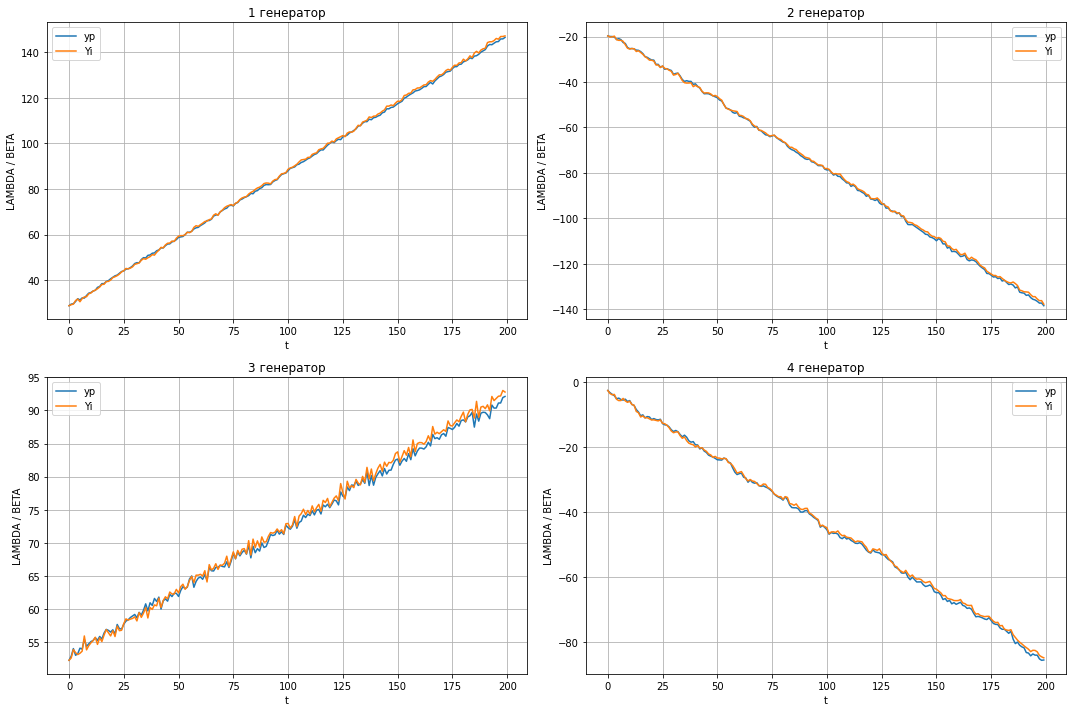

In [18]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex0_yp[0], label='yp')
plt.plot(YA[0], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex0_yp[1], label='yp')
plt.plot(YA[1], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex0_yp[2], label='yp')
plt.plot(YA[2], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex0_yp[3], label='yp')
plt.plot(YA[3], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

In [19]:
res = []
for i in range(len(YA[0]) ):
#     print(YA[0][i] - yAF[0][0][i])
    res.append( (YA[0][i] - yAF[0][0][i])**2 )
    
print(sum(res) / (len(res) - 1))

print(yAF[14][-1] / (len(YA[0]) - 1))
print(SRm)
print(len(res))

0.4428735113992339
[0.44287351 0.44287351 0.44287351 0.44287351]
[0.25856297 0.65823418 0.41786298 0.61570331]
200


In [20]:
# Y = [
#     [0.08727, 0.3059, -0.3946, 0.2384, 0.4594, 0.2669, 0.3566, -0.2098, 0.656, 0.08385, 0.5221, 0.3696, -0.06309, 0.07043, 0.3622, 0.1981, -0.1387, 0.8121, 0.8913, -0.8983, -0.1275, 0.0124, -0.4998, 0.1814, -0.05599, 0.179, -0.01335, 0.001001, 0.1701, 0.6669, 0.1589, 0.7483, 0.231, 0.1987, 0.704, 0.486, 0.3587, 0.4479, 0.7888, 0.7262, 1.117, 0.3179, 0.04706, 0.01432, 0.5177, 0.1798, -0.06817, 0.4846, 0.6068, -0.2533, -0.2095, -0.299, -0.02282, -0.8463, -0.1979, 0.07378, 0.7573, -0.04622, 0.6208, 0.7712, 0.2525, 0.5287, -0.2372, 0.5666, 0.8824, 0.5165, -0.1045, -0.2983, 0.2249, -0.6125, -0.6253, 0.5303, 0.6718, -0.2254, -0.08021, -0.03712, 0.1051, -0.3148, -0.2782, -0.5849, 0.4857, 0.4962, -0.7987, 0.1292, 0.2942, 0.7672, 0.804, 0.5576, 0.341, -0.7014, -0.3047, -0.3911, 0.1397, 0.252, 0.02197, -0.3528, 0.1405, 0.2506, 0.1382, 0.368, 0.4297, 0.1702, 0.2277, 0.5568, 0.2054, -0.4566, -1.382, -0.7812, -0.7211, -1.153, -0.4077, 0.02314, -0.4116, -0.6075, 0.242, 0.1985, -0.08382, -0.06697, 0.01551, 0.4433, 0.7302, 0.2645, -0.1585, 0.02058, -0.5191, 0.1527, -0.03626, -0.3508, 0.3884, 0.1511, -0.2091, 0.2174, 0.8521, 0.2798, 0.5789, -0.406, 0.3493, 0.2299, 0.07834, 0.02158, -1.062, -0.1056, -0.1944, -0.9277, -1.066, -0.3993, 0.3216, -0.5258, 0.537, 0.2891, 0.1426, 0.9816, 0.1208, 0.116, -0.4115, -0.1452, -0.3241, -0.08865, -0.1276, 0.912, 0.328, 0.2326, -0.6791, -0.1457, 0.09154, -0.6359, -0.4254, 0.7879, 0.402, 0.539, 0.04143, 0.8554, 0.3928, 0.4842, -0.08997, -0.05218, 0.0178, -0.4799, 0.09417, 0.117, -0.787, -0.5589, -0.08824, 0.2405, -0.3624, -0.225, 0.3332, 0.2648, -0.696, -0.05964, 0.2858, -0.4066, 0.06759, -0.4463, 0.5188, -0.8598, -0.5698, 0.1874, -1.189, 0.2296, 0.3562, -0.9565, -0.2781, -0.3275, -0.6838, 1.214, 0.9596, 0.357, 0.2751, 0.6032, -0.3155, 0.2593, -0.3231, -0.6645, -0.9171, -0.658, -0.1563, -0.3953, 0.6324, -0.03829, 0.962, 0.1467, 0.4377, 0.2147, -0.2373, -0.4041, 0.6245, -0.1529, -0.1572, -0.251, 0.05086, -0.08986, -0.1752, -0.2053, 0.0118, 0.2413, 0.03994, -0.1584, -0.445, 0.1416, 0.2004, 0.8332, -0.07004, -0.2073, -0.5762, -0.3615, 0.06373, 0.1033, -0.3257, -0.8307],
#     [-0.4154, 0.1829, 0.3254, 0.5797, 0.06145, -0.06142, 0.2988, -0.9348, -0.9942, -1.026, -0.00695, 0.3075, 0.413, 0.5516, -1.292, -1.202, -0.528, 0.4107, -0.5804, -0.2528, 0.3497, 0.5198, -0.3549, -1.297, -1.1, -0.2569, 0.2498, -0.3544, 0.549, 0.4207, 0.2176, -0.2354, -0.281, -0.562, -0.01398, 0.2593, -0.8958, -0.3192, -0.8236, 0.4829, -0.04101, 0.4294, 0.3783, 0.5031, -0.5653, 0.307, 1.482, 0.5564, -0.5263, -0.8944, -0.4608, 0.1737, 0.886, -0.2326, 0.948, 0.9491, 1.177, 0.1092, -0.0554, 0.6572, 1.21, 1.367, 1.045, 1.907, 2.016, 1.678, 1.615, 0.217, -0.6364, -0.5649, -0.3294, -0.05, 0.3867, 0.8329, -0.2462, 0.2547, 0.4238, 0.02487, 0.5355, 0.327, -0.5627, -0.7551, -0.6243, -1.372, -0.8888, -0.8442, -0.7802, -1.056, -0.9645, -0.1377, 0.6111, 0.3073, 0.2139, 0.4931, 0.1793, 0.324, 0.005902, -0.5513, 0.09156, 0.02571, 0.2741, -0.2103, -0.2922, -0.3764, -0.6765, -0.3468, 0.01651, -0.5255, -0.1199, -0.3301, -0.4607, 0.1064, 0.4636, -0.2842, 0.3443, 0.5784, -0.01523, -0.2708, 0.4973, 0.8834, 1.538, 0.841, 0.2659, -0.03144, 0.2055, -0.1881, 0.6509, 0.5247, -0.1494, -0.02786, 0.21, 0.2223, -0.2154, 0.1181, -0.834, -0.3736, 0.2161, 1.184, 0.8013, 0.03477, 0.1825, -0.04982, 0.1848, -0.8789, -0.7445, 0.1812, -0.003339, 0.5099, 0.04757, 0.4306, -0.6008, -1.114, -0.6015, -0.2306, -0.4224, -0.1426, -0.2494, -0.459, -0.3423, -0.4405, 0.04807, -0.5018, -0.6349, -0.2016, -0.3758, 0.5747, 0.7432, 0.1293, 0.4829, -0.7624, -0.1929, -0.6936, -0.6959, 0.1527, -0.4954, -0.9819, -0.2944, 0.8638, -0.3465, -0.5634, 0.8866, 0.812, 0.9879, 0.4946, -0.2543, -0.3088, -0.2161, -1.056, -1.113, -1.09, -1.14, -0.5496, -0.6318, 0.1744, -0.01437, -0.2271, -0.2063, -0.03883, 0.3593, 1.395, 1.295, 1.031, -0.3783, -0.07714, 0.06708, 0.6142, 1.107, 0.6286, 0.336, 0.9522, 0.5345, 0.3604, 0.9913, 0.02027, 0.08494, 0.6584, 0.5499, 0.6527, 0.7607, 1.052, 0.07792, 0.2225, 1.031, 1.257, 1.149, 0.5565, 0.7852, 0.03997, -0.3467, 0.4203, 0.06212, 0.5725, 0.1615, 0.4331, -0.5715, -0.4769, -0.09467, -0.328, -0.2892, -0.303, -0.1704, 0.5612, 0.635, 0.5384, 0.8183, 0.8045, -0.0698, -0.01015, 0.8634, 1.022],
#     [0.3842, -0.402, 0.7901, -1.113, 1.635, -0.2388, 0.5059, 0.2173, -0.2301, -0.05664, -0.003252, 0.4133, -0.8122, 0.4919, -0.5135, -0.3609, 0.7011, 0.03728, -0.4464, -0.4527, -0.3372, 1.761, -0.5372, -0.114, 0.1185, 0.2606, 0.5653, -0.7111, 0.07859, -0.6797, 0.08932, 0.7223, 0.05691, -0.6369, -0.04167, -1.129, 0.243, -0.6431, -0.78, 0.02988, 0.5395, 0.1554, 0.09996, 0.00103, 0.04262, -0.7691, 0.2797, -0.6302, -0.2022, 0.4456, -1.325, 0.05254, -0.4372, 0.04368, -0.2904, 0.6594, -0.934, -0.1031, 0.2734, -0.2328, 0.5949, 0.0845, -0.1062, 0.3919, -0.3423, 0.4063, 0.5704, -0.3926, -0.1899, 0.539, 0.9487, -0.1903, 0.7324, 0.5368, 0.4664, -0.003808, 0.6068, -1.29, 1.123, 0.1208, 0.176, 0.6595, -0.3924, 0.0513, -0.1743, -0.0509, 0.7986, -0.9506, -0.06165, 0.8567, -0.3602, 0.6666, -0.1703, 0.4489, 0.3409, -0.6344, 1.142, -1.237, 0.9756, -0.5053, 0.3123, -0.8315, 0.5062, -0.4848, -0.6341, -0.007326, 0.3643, 0.0704, 0.01819, 0.3051, -0.3564, -0.1969, -1.009, 0.296, 0.1354, -0.7597, -0.4909, 0.579, -1.157, 0.2435, 0.4225, 0.8854, -0.1064, 0.3029, -0.4433, 0.589, -0.5053, -0.0821, 0.2124, -1.025, 0.4307, -0.103, 0.3162, -1.126, -0.698, -0.2494, -0.1041, -1.033, 1.353, -0.188, -1.377, 1.102, -0.07935, 0.04166, -0.4606, 0.5865, -0.1747, -0.6399, 0.4395, -0.647, 1.401, -0.5396, 0.751, -1.218, -0.3599, 0.2869, 0.6434, -0.5836, 0.5888, -0.2381, 0.1512, -0.1173, 0.06221, 0.8933, 0.9422, -0.8234, -0.1404, 0.5225, -0.362, 0.6039, -1.003, 1.343, -0.6282, 0.3969, 0.3532, 0.1277, -0.2963, -0.1081, 0.5696, -0.4194, 1.564, 0.2157, 0.2956, -0.1151, -0.01518, 0.0771, -0.3727, 1.007, 0.1064, -0.1496, 0.1223, 0.3599, -0.1108, 0.4872, 0.9396, -0.7239, 0.2031, 0.679, 0.5435, -0.9579, 1.36, -1.246, 0.1037, 0.01206, -0.5362, -0.1627, -1.265, 0.7013, -0.1215, 0.01266, 0.1369, -0.02012, 0.602, 0.1692, 0.06372, -0.5529, 0.3592, 0.4487, -0.3864, -0.00281, -0.08744, 0.49, -0.4055, 0.1246, 0.2006, 0.1148, -0.5582, -0.04963, -0.7472, -0.08645, 0.0679, -0.774, 0.2864, -0.9028, -0.326, -0.2408, 0.2157, -0.3312, 0.5902, -0.2474, -0.2969, -0.1598, -0.06249, 1.041, -0.3876, 0.5429, -1.073, 0.4111, 0.645, -0.9014],
#     [0.6218, 0.3676, -0.2379, -0.3235, -0.3847, -0.2006, -0.8625, -0.2115, 0.2419, 1.244, 1.676, 0.7985, 0.9988, 1.115, 1.07, 0.539, 0.5457, 1.067, -0.02681, -0.03388, 0.3816, 1.435, 1.064, 1.017, 1.777, 1.16, 1.339, -0.1805, -0.158, -1.075, -0.325, -0.5625, -0.09424, -0.04166, 0.007372, 0.4451, 0.6869, 0.9124, 1.644, 0.9617, 1.255, 1.179, 0.8275, 0.2061, 0.07673, 0.7142, 1.157, 0.4072, -0.02135, 0.7733, 0.03956, -0.3249, -0.2247, -0.02144, -0.3054, 0.5728, 0.1501, 0.6815, 0.3642, 0.3699, -0.04482, 0.05702, -0.2984, 0.4141, 0.3064, 0.6851, 0.8453, 1.401, 1.709, 0.9224, 1.097, 0.7726, 0.09766, -0.7344, -0.08145, 0.5405, -0.1916, -0.8837, -1.136, -0.3023, -0.3722, -0.09572, -0.3513, -0.5703, -0.2324, 0.717, 1.047, 0.468, 0.5144, 0.2152, -0.3605, -0.353, -0.3952, 0.03176, -0.3943, 0.8385, 0.9864, -0.4971, -0.246, -0.2238, 0.5943, 0.06412, -0.2035, 0.08595, 0.8115, 1.245, 0.1995, 0.2356, 0.04932, -0.1819, -0.1768, -1.83, -1.135, -1.193, -1.092, -2.548, -1.628, -1.178, -0.9688, -0.09768, -0.6295, -0.7819, -0.2605, -0.4252, -0.137, 0.1189, -0.1222, -0.3122, 0.404, 0.6856, 0.9477, 0.4003, 0.08221, -0.8563, -0.6581, 0.7846, 0.9805, 1.104, 1.995, 1.118, 0.8252, 1.446, 0.7513, 0.3052, 0.07013, -0.4727, -0.3706, -0.9608, -0.9218, -0.9627, 0.1744, -0.5128, -0.9256, -0.05599, -0.4841, -0.5426, -0.05179, 0.1389, -0.102, -0.02155, 0.5729, 1.162, 0.5025, -0.1925, -0.01601, -0.2008, -0.3328, -0.8246, -0.3738, -0.8609, -0.6315, -0.3968, -0.3105, 0.05983, 0.4975, 1.199, 0.5527, 0.7428, 0.652, 0.9632, 1.411, 0.04233, -0.4891, 0.06173, -0.09145, 0.1366, 0.3371, 0.8364, 1.232, 0.8434, 0.522, 0.5084, 0.996, 0.3077, 0.8225, 0.08949, 0.2374, 0.502, 1.125, -0.0113, -0.429, -0.8895, -1.128, -1.254, -1.461, -1.568, -1.672, -2.011, -1.197, -0.842, -0.8647, -1.579, -1.615, -1.522, -1.562, -0.995, -1.04, -0.1957, -0.1231, -0.6185, -0.2686, 0.1789, -0.1532, -0.3397, -0.6963, -1.031, -1.578, -1.437, -2.134, -1.18, -1.28, -1.045, -0.6279, 0.3705, 0.9, 0.00537, 0.2496, 1.186, 0.2096, 0.2539, 0.6278, 1.485, 1.28, 1.582, 1.636, 2.158, 2.42, 1.14, 0.3008, 0.4827]
#     ]

# def generate_trend(b1, b0, cnt = 300):
#     y = []
#     for i in range(cnt):
#         y.append(b1*i + b0)
    
#     return y

# def get_series_for_model(series, dots):
#     b1, b0 = np.polyfit( range(len(series[:dots])), series[:dots], 1)
    
#     trend = generate_trend(b1, b0)
    
#     series_for_model = [series[i] - trend[i] for i in range(dots)]
    
#     return (series_for_model, b1, b0)

# tr = [generate_trend(0.6, 20), generate_trend(-0.6, -10), generate_trend(0.2, 50), generate_trend(-0.4, 2)]
# for i in range(4):
#     for j in range(len(Y[i])):
#         Y[i][j] += tr[i][j]


# series_for_model1, b11, b01 = get_series_for_model(Y[0], 15)
# Z = create_z(Y)
# ref_trend = generate_trend(b11, b01)
# for i in range(len(Z[0])):
#     Z[1][i] -= ref_trend[i]
#     Z[2][i] -= ref_trend[i]
#     Z[3][i] -= ref_trend[i]
# series_for_model2, b12, b02 = get_series_for_model(Z[1], 15)
# series_for_model3, b13, b03 = get_series_for_model(Z[2], 15)
# series_for_model4, b14, b04 = get_series_for_model(Z[3], 15)

# trend1 = generate_trend(b11, b01)
# trend2 = generate_trend(-b12, -b02)
# trend3 = generate_trend(-b13, -b03)
# trend4 = generate_trend(-b14, -b04)


# Y[0] = Y[0][14:100 + 14]
# Y[1] = Y[1][14:100 + 14]
# Y[2] = Y[2][14:100 + 14]
# Y[3] = Y[3][14:100 + 14]

# YA = Y[:]


# # ступеньки

# for i in range(60, len(Y[0])):
#     Y[1][i] += 5
# for i in range(80, len(Y[2])):
#     Y[3][i] -= 5
# Z = create_z(Y)

# for i in range(len(Z)):
#     Z[1][i] -= trend1[i]
#     Z[2][i] -= trend1[i]
#     Z[3][i] -= trend1[i]
    

    
# for i in range(len(Z)):
#     Z[1][i] += trend2[i]
#     Z[2][i] += trend3[i]
#     Z[3][i] += trend4[i]
    
    
# ymnk = [ (Z[0][j] + Z[1][j] + Z[2][j] + Z[3][j]) / 4 for j in range(len(Z[0]))]

# ymnk_neop = [ [ ymnk[j] - Z[1][j], ymnk[j] - Z[2][j], ymnk[j] - Z[3][j] ] for j in range(len(ymnk)) ]


# for i in range(len(ymnk)):
#     ymnk[i] += trend1[i]
#     ymnk_neop[i][0] += trend2[i]
#     ymnk_neop[i][1] += trend3[i]
#     ymnk_neop[i][2] += trend4[i]
    

# res = 0
# for i in range( 100 ):
# #     print(YA[0][i] - yAF[0][0][i])
#     res += (YA[0][i] - ymnk[i])**2
    
# print(res / (100 - 1))

    

    

# Y = np.transpose(Y)

In [21]:
print(b11, -b12, -b13, -b14)
print(b01, -b02, -b03, -b04)

0.6100551428571434 -0.6285791428571424 0.17102415714285618 -0.2983249999999996
20.13702466666666 -9.933974000000006 50.27404476666667 1.6824683333333288


In [22]:
# ymnk_neop = np.transpose(ymnk_neop)

# plt.figure(figsize=(15, 10))
# plt.subplot(2, 2, 1)
# plt.plot(ex0_yp[0], label='yp')
# plt.plot(YA[0], label='Yi')
# plt.plot(ymnk, label="ymnk")
# plt.plot(Z[0], label="z_0")
# plt.legend(loc='best')
# plt.ylabel("LAMBDA / BETA")
# plt.xlabel("t")
# plt.title("1 генератор")
# plt.grid(which='major')
# plt.grid(which='minor', linestyle=':')
# plt.tight_layout()

# plt.subplot(2, 2, 2)
# plt.plot(ex0_yp[1], label='yp')
# plt.plot(YA[1], label='Yi')
# plt.plot(ymnk_neop[0], label="ymnk_neop_0")
# plt.plot(Z[1], label="z_1")
# plt.legend(loc='best')
# plt.ylabel("LAMBDA / BETA")
# plt.xlabel("t")
# plt.title("2 генератор")
# plt.grid(which='major')
# plt.grid(which='minor', linestyle=':')
# plt.tight_layout()

# plt.subplot(2, 2, 3)
# plt.plot(ex0_yp[2], label='yp')
# plt.plot(YA[2], label='Yi')
# plt.plot(ymnk_neop[1], label="ymnk_neop_1")
# plt.plot(Z[2], label="z_2")
# plt.legend(loc='best')
# plt.ylabel("LAMBDA / BETA")
# plt.xlabel("t")
# plt.title("3 генератор")
# plt.grid(which='major')
# plt.grid(which='minor', linestyle=':')
# plt.tight_layout()

# plt.subplot(2, 2, 4)
# plt.plot(ex0_yp[3], label='yp')
# plt.plot(YA[3], label='Yi')
# plt.plot(ymnk_neop[2], label="ymnk_neop_2")
# plt.plot(Z[3], label="z_3")
# plt.legend(loc='best')
# plt.ylabel("LAMBDA / BETA")
# plt.xlabel("t")
# plt.title("4 генератор")
# plt.grid(which='major')
# plt.grid(which='minor', linestyle=':')
# plt.tight_layout()
# plt.show()

[88.13182877 88.13182877 88.13182877 88.13182877]
Разладка на тактах: [8, 'no', 148, 'no']


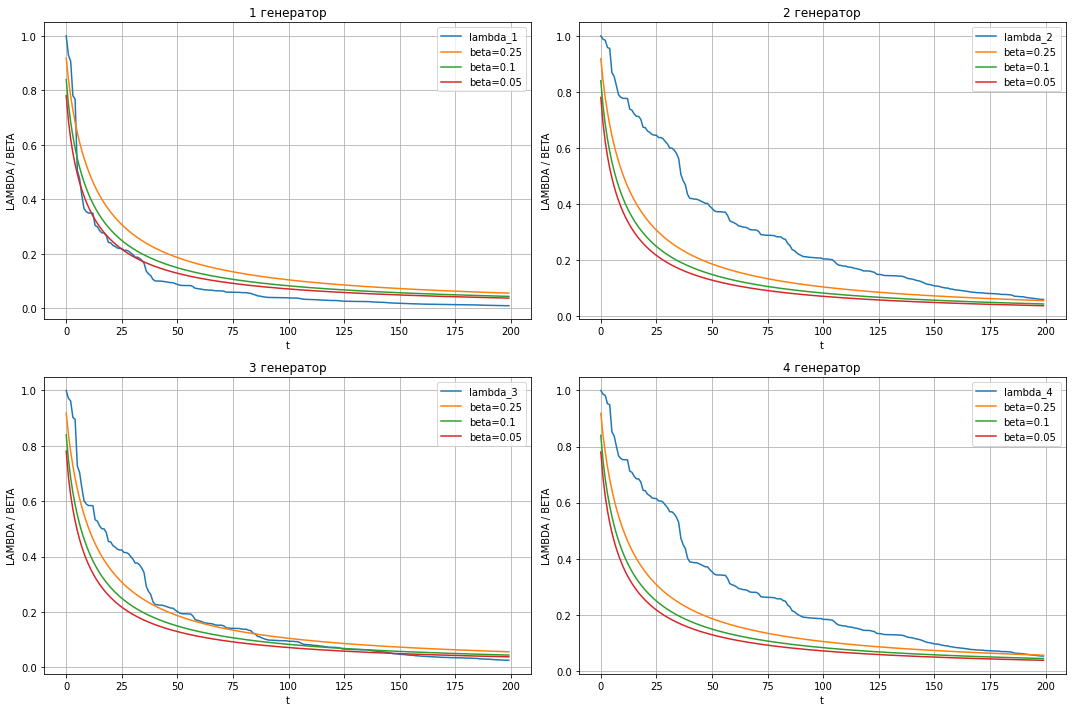

In [23]:
print(yAF[14][-1])

out_of_range = ['no' for _ in range(len(YA))]

for k in range(len(out_of_range)):
    for i in range(len(ex_beta3)):
        if ex0_lambda[k][i] <= ex_beta3[i]:
            out_of_range[k] = i+1
            break


print(f'Разладка на тактах: {out_of_range}')        

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex0_lambda[0], label='lambda_1')
plt.plot(ex_beta1, label='beta=0.25')
plt.plot(ex_beta2, label='beta=0.1')
plt.plot(ex_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex0_lambda[1], label='lambda_2')
plt.plot(ex_beta1, label='beta=0.25')
plt.plot(ex_beta2, label='beta=0.1')
plt.plot(ex_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex0_lambda[2], label='lambda_3')
plt.plot(ex_beta1, label='beta=0.25')
plt.plot(ex_beta2, label='beta=0.1')
plt.plot(ex_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex0_lambda[3], label='lambda_4')
plt.plot(ex_beta1, label='beta=0.25')
plt.plot(ex_beta2, label='beta=0.1')
plt.plot(ex_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()